# Testing Scene Modeling for Curveball Integration

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import config
import subtract
import db
from exposuresource import ExposureSource
from processing import cat_psf_sky
from psfexreader import PSFExReader

import scarlet, scarlet2
from scarlet2 import *
from numpyro.distributions import constraints
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
import astropy.units as units
import optax
import uuid
import glob
import sep

import jax.numpy as jnp
from scarlet.display import AsinhMapping,AsinhPercentileNorm
from scarlet.display import show_scarlet2_scene,LinearPercentileNorm

/usr/local/lib/python3.10/dist-packages/equinox/_module.py:257: UserWarning: Class `scarlet2.morphology.ArrayMorphology` has both an `__init__` method and a `__post_init__` method. This means that the `__post_init__` method will not be run!
The reason for this is that `__post_init__` is intended to be used with the automatically-generated `__init__` method provided by Python dataclasses, which are generated of the form:
```
def __init__(self, field1, field2)
    self.field1 = field1
    self.field2 = field2
    self.__post_init__()
```
and as such a user-provided `__init__` overrides both the setting of fields, and the calling of `__post_init__`.
The above is how Python dataclasses work, and has nothing to do with Equinox!
If you are using `__post_init__` to check that certain invariants hold, then consider using `__check_init__` instead. This is an Equinox-specific extension that is always ran. See here for more details: https://docs.kidger.site/equinox/api/module/advanced_fields/#che

In [3]:
names = ['c4d_20211002_044418_g_v1.24.2',
          'c4d_20211002_044547_r_v1.24.206',
          'c4d_20211002_044742_i_v1.24.3266',
          'c4d_20211005_044058_g_v1.24.29',
          'c4d_20211005_044229_r_v1.24.163',
          'c4d_20211005_044425_i_v1.24.228',
          'c4d_20211011_045524_g_v1.24.9',
          'c4d_20211011_045654_r_v1.24.198',
          'c4d_20211011_045849_i_v1.24.210',
          'c4d_20211014_051047_g_v1.24.39',
          'c4d_20211014_051215_r_v1.24.193',
          'c4d_20211014_051411_i_v1.24.239',
         ]
subweights = [f'{x}.sub.weight.fits' for x in names]
imgweights = [f'{".".join(x.split(".")[:-1])}.weight.fits' for x in names]
submasks = [f'{x}.sub.mask.fits' for x in names]
imgmasks = [f'{".".join(x.split(".")[:-1])}.mask.fits' for x in names]
imgs = [f'{".".join(x.split(".")[:-1])}.fits' for x in names]
subs = [f'{x}.sub.fits' for x in names]

tmpdir = f'/tmp/{uuid.uuid4().hex}'

ra = 8.94907775241537
dec = -42.7246132888024

config.Config.init( 'emily_saul.yaml' )
decam = ExposureSource.get("DECam", "Reduced")

In [5]:
imagelist = [decam.local_path(x) for x in imgs]
masklist = [decam.local_path(x) for x in imgmasks]
weightlist = [decam.local_path(x) for x in imgweights]
centerra, centerdec = 8.94907775241537, -42.7246132888024
trim = [100,100]
tiny=1e-10
hdrkeywords = decam.key_keywords
swarpcmd = ( f'swarp -SUBTRACT_BACK N '
             f'-COMBINE N -MEM_MAX 2048 '
             f'-CELESTIAL_TYPE NATIVE '
             f'-PROJECTION_TYPE TAN '
             f'-RESAMPLING_TYPE BILINEAR '
             # f'-CENTER_TYPE MANUAL -CENTER {centerra},{centerdec} '
             # f'-IMAGE_SIZE {trim[0]},{trim[1]} '
             f'-NTHREADS 0 -RESAMPLE_DIR . -VMEM_DIR {tmpdir} ' # change tmpdir to actual location
             # f'-WEIGHT_IMAGE {",".join([str(s) for s in weightlist])} '
             # f'-WEIGHT_TYPE MAP_WEIGHT -WEIGHT_THRESH {tiny} '
             f'-RESCALE_WEIGHTS N ' ### ONLY FOR MASK IMAGES
             f'-WRITE_FILEINFO Y '
             f'-VERBOSE_TYPE LOG '
             f'-DELETE_TMPFILES N '
             f'{" ".join([str(i) for i in masklist])}' )
# print(swarpcmd)

swarp -SUBTRACT_BACK N -COMBINE N -MEM_MAX 2048 -CELESTIAL_TYPE NATIVE -PROJECTION_TYPE TAN -RESAMPLING_TYPE BILINEAR -NTHREADS 0 -RESAMPLE_DIR . -VMEM_DIR /tmp/4fbd954f5c13468d99b6f49c16f20f38 -RESCALE_WEIGHTS N -WRITE_FILEINFO Y -VERBOSE_TYPE LOG -DELETE_TMPFILES N /pscratch/sd/e/eramey16/data/curveball/DECam_Reduced/2021-10-02/c4d_20211002_044418_g_v1.24.mask.fits /pscratch/sd/e/eramey16/data/curveball/DECam_Reduced/2021-10-02/c4d_20211002_044547_r_v1.24.mask.fits /pscratch/sd/e/eramey16/data/curveball/DECam_Reduced/2021-10-02/c4d_20211002_044742_i_v1.24.mask.fits /pscratch/sd/e/eramey16/data/curveball/DECam_Reduced/2021-10-05/c4d_20211005_044058_g_v1.24.mask.fits /pscratch/sd/e/eramey16/data/curveball/DECam_Reduced/2021-10-05/c4d_20211005_044229_r_v1.24.mask.fits /pscratch/sd/e/eramey16/data/curveball/DECam_Reduced/2021-10-05/c4d_20211005_044425_i_v1.24.mask.fits /pscratch/sd/e/eramey16/data/curveball/DECam_Reduced/2021-10-11/c4d_20211011_045524_g_v1.24.mask.fits /pscratch/sd/e/era

In [12]:
resamp = imagelist
basenames = [decam.image_basename(str(x).split('/')[-1]) for x in resamp]
resamp_weights = [f"{str(x)[:-5]}.weight.fits" for x in imagelist]
resamp_masks = [f"{str(x)[:-5]}.mask.fits" for x in imagelist]
resamp_cats = [f"{str(x)[:-5]}.cat" for x in imagelist]
resamp_psfs = [f"{str(x)[:-5]}.psf" for x in imagelist]

clips = []
clipwts = []
clipmasks = []
clippsfs = []
ra_dec = []
zps = []
for i,img in enumerate(resamp):
    
    # # Get subtraction file paths
    # path = decam.local_path(img)
    # weightpath = decam.local_path(imgweights[i])
    # maskpath = decam.local_path(imgmasks[i])

    with fits.open( img, memmap=True ) as hdul:
        # Get WCS from header of sub file
        wcs = WCS(hdul[0].header)
        zps.append(hdul[0].header['MAGZP'])
        data = hdul[0].data
    with fits.open( resamp_weights[i], memmap=True ) as hdul:
        weightwcs = WCS(hdul[0].header)
        weightdata = hdul[0].data
    
    # make a mask 
    maskdata = np.zeros_like( weightdata, dtype=np.uint8 )
    maskdata[ weightdata <= tiny ] = 1
    mhdu = fits.PrimaryHDU( data=maskdata, header=weightwcs.to_header() )
    mhdu.writeto(resamp_masks[i], overwrite=True )
    
    # extract catalog and make psf
    if not os.path.exists(resamp_psfs[i]):
        cat_psf_sky(decam, img, resamp_weights[i], resamp_masks[i], 
                    catalog=resamp_cats[i], nodb=True)
    
    

    sc = SkyCoord( ra, dec, frame='icrs', unit=units.deg )
    ra_dec.append(sc)
    x, y = wcs.world_to_pixel(sc)
    print(x, y)
    
    med = np.median(data)
    clip = Cutout2D(data, sc, size=100, wcs=wcs, mode='partial', fill_value=med)
    clips.append(clip)
    x, y = clip.wcs.world_to_pixel( sc )
    x_, y_ = int(x), int(y)
    
    clipwt = Cutout2D(weightdata, sc, wcs=wcs, size=100, mode='partial', fill_value=0)
    clipwts.append(clipwt)
    
    clipmask = Cutout2D(maskdata, sc, wcs=wcs, size=100, mode='partial', fill_value=0)
    clipmasks.append(clipmask)
    
    # Get resampled PSF at image scale
    psf_file = resamp_psfs[i]
    reader = PSFExReader(psf_file)
    psf = reader.getclip(x_, y_, flux=1) # Using the integer position: is this right?
    clippsfs.append(psf)
ra_dec = ra_dec[0]

Stampwid came out even (32), subtracting 


534.0344158726534 2246.7767689356683
545.8939215884707 2233.6729515004013


Stampwid came out even (26), subtracting 


552.8426867157423 2228.2425513261014


Stampwid came out even (34), subtracting 


473.7314624128362 2245.6296374278777


Stampwid came out even (28), subtracting 


489.37347046230116 2236.2237000265754
501.4312853456472 2226.588358563229


Stampwid came out even (46), subtracting 


552.5014251714579 2188.062149349959


Stampwid came out even (42), subtracting 


564.6894544307806 2197.5905279775875


Stampwid came out even (38), subtracting 


565.225784871081 2181.508100256762
564.5478103552359 2198.8268267892886


Stampwid came out even (28), subtracting 


568.5785828138905 2193.592370139107


Stampwid came out even (26), subtracting 


566.3637382624993 2202.280308447545


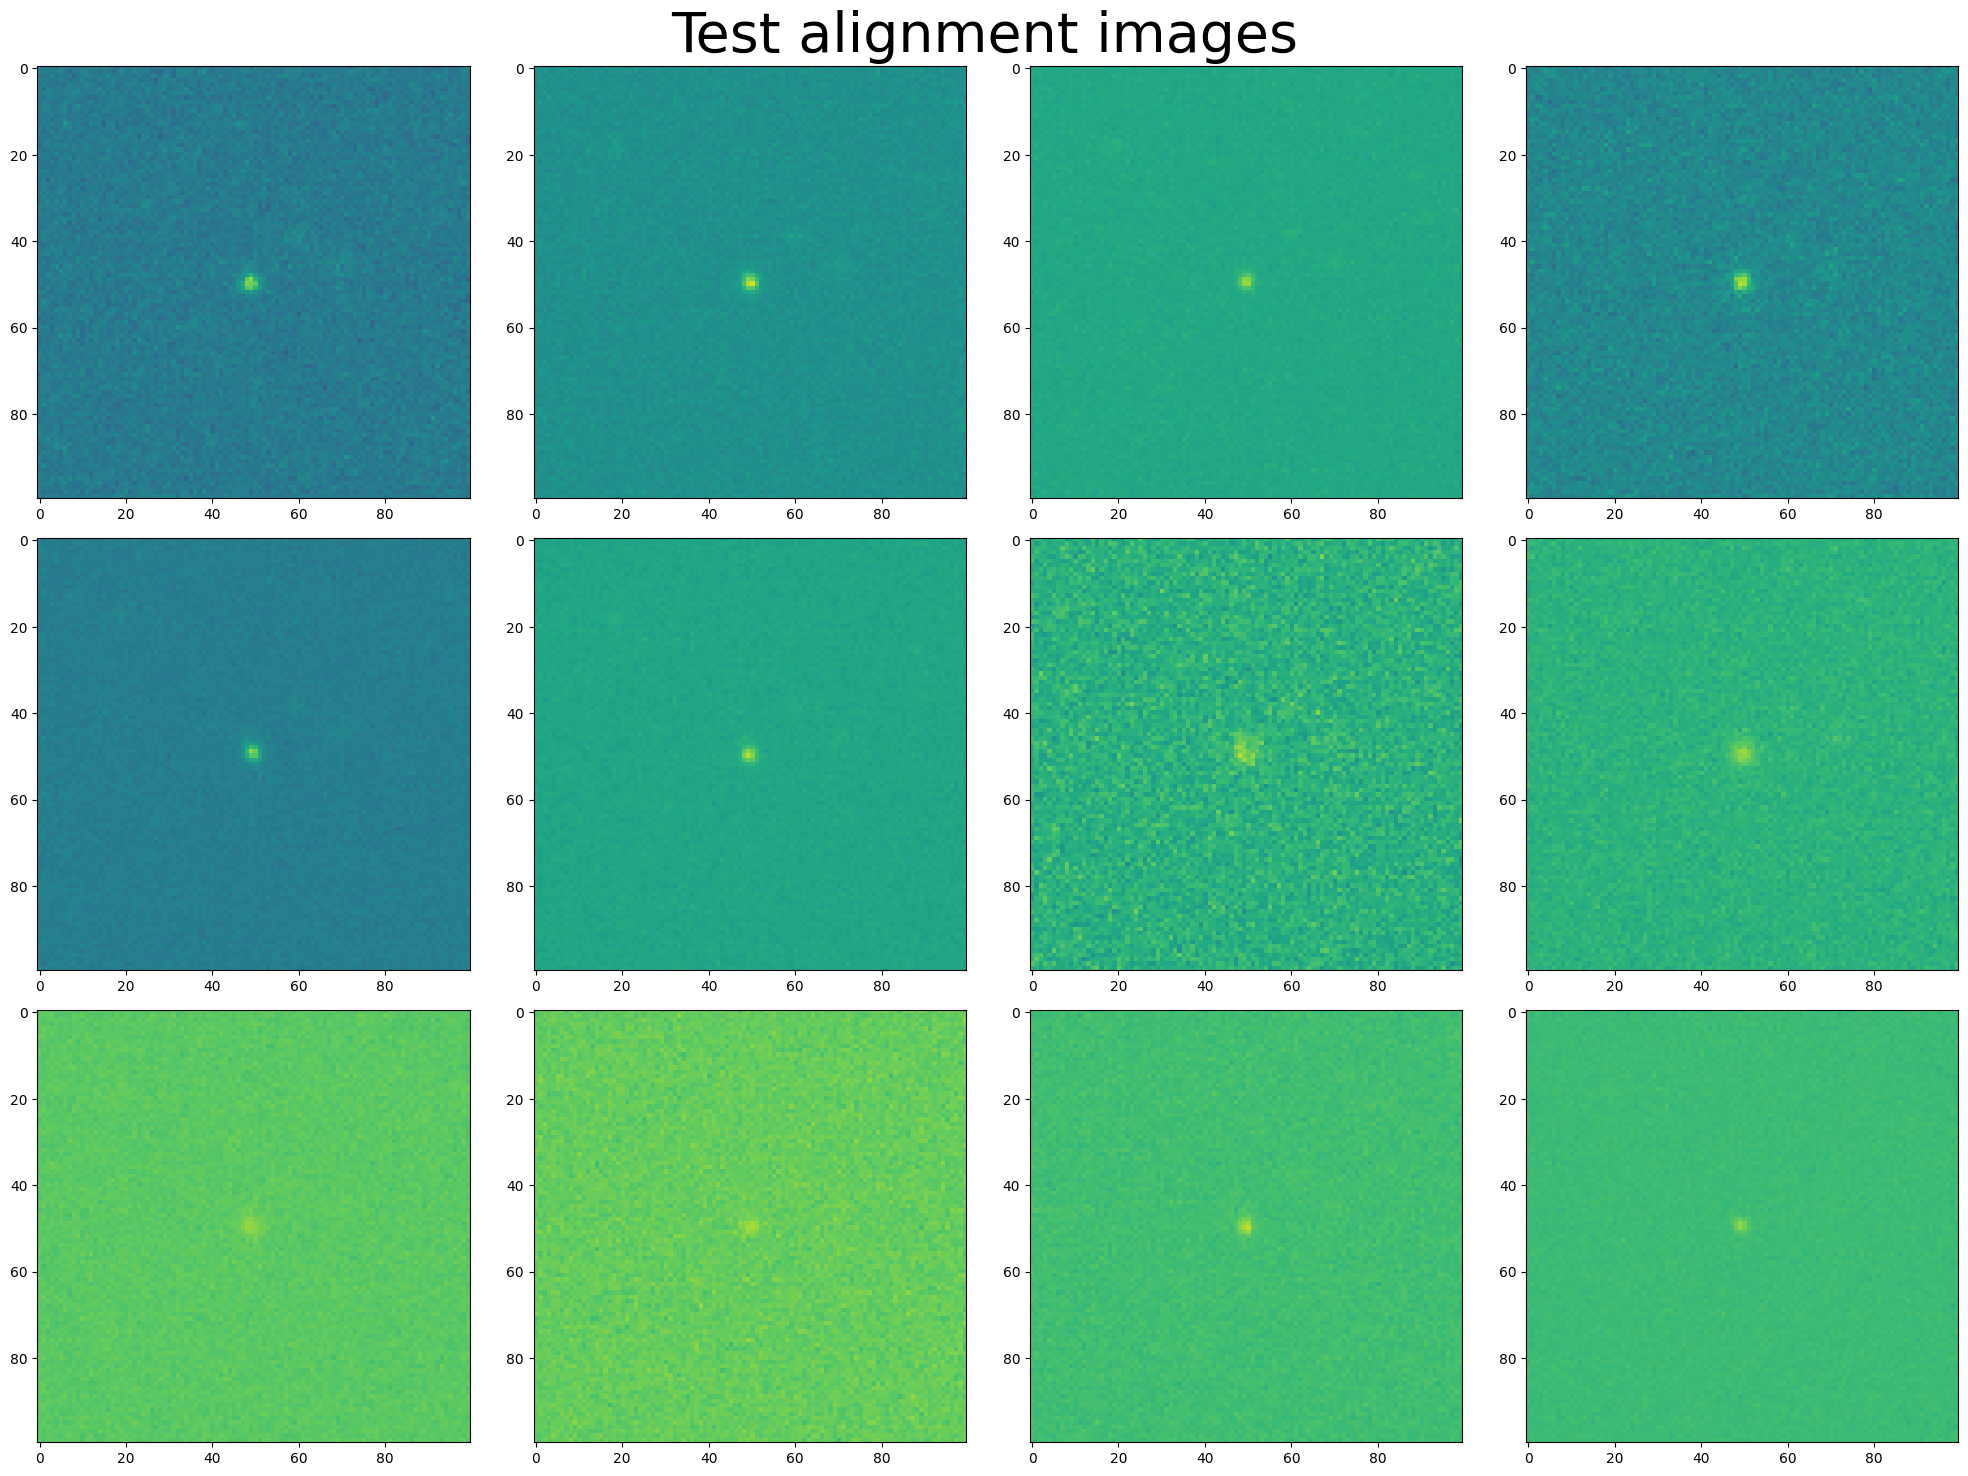

In [13]:
fig, axes = plt.subplots(3, 4, figsize=(20,15))
for i,ax in enumerate(axes.flatten()):
    ax.imshow(clips[i].data, vmin=0, vmax=clips[i].data[49,49]*1.2)
plt.suptitle("Test alignment images", fontsize=40)
plt.tight_layout()

In [14]:
def makeCatalog(observations, lvl=3, wave=True):
    normed_images = np.asarray([obs.data for obs in observations])
    interps = [scarlet.interpolation.interpolate_observation(obs, observations[0]) 
               for obs in observations[:10]]
    interps = np.asarray(interps/np.sum(interps))
    detect_image = np.sum(interps,axis=(0,1))
    # Wavelet transform
    wave_detect = scarlet.Starlet.from_image(detect_image).coefficients

    if wave:
        # Creates detection from the first 3 wavelet levels
        detect = wave_detect[:lvl,:,:].sum(axis = 0)
    else:
        detect = detect_image
    
    plt.imshow(detect_image)

        # Runs SEP detection
    bkg = sep.Background(detect)
    catalog = sep.extract(detect-bkg.globalback, 5, err=bkg.globalrms)
    background=[]
    bg_rms=[]
    for obs in observations:
        img = obs.data
        if np.size(img.shape) == 3:
            bg_rms.append(np.array([sep.Background(band).globalrms for band in img]))
            background.append(np.array([sep.Background(band).globalback for band in img]))
        else:
            bg_rms.append(sep.Background(img).globalrms)
            background.append(sep.Background(img).globalback)
    return catalog, bg_rms, detect_image, background

Stampwid came out even (32), subtracting 


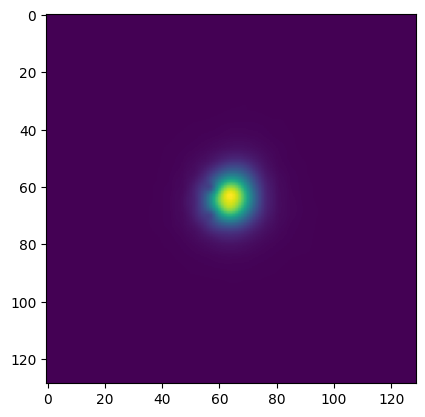

In [15]:
psf_file = resamp_psfs[0]
reader = PSFExReader(psf_file)
data = reader.get_resampled_psf(534, 2201)

plt.imshow(data)

In [16]:
observations=[]
observations_sc2=[]
channels = []
channels_sc2 = []
norms = []
times = []
for i, clip in enumerate(clips):
    f = decam.filter(imagelist[i])[-1].upper()
    
    channel_sc1, channel_sc2 = [f"{f}{i}"], (f, i)
    channels_sc2.append(channel_sc2)
    N1, N2 = clip.data.shape
    data = clip.data.reshape(1, N1, N2)
    Nw1, Nw2 = clipwts[i].data.shape
    weight = clipwts[i].data.reshape(1, Nw1, Nw2)
    
    psf0 = clippsfs[i]
    p1,p2=psf0.shape
    if p1-37>0: # what is this for?
        psf0=psf0[int((p1-37)/2):-int((p1-37)/2),:]
    if p2-37>0:
        psf0=psf0[:,int((p2-37)/2):-int((p2-37)/2)]
    
    psf = scarlet.ImagePSF(psf0)
    
    channels.append(channel_sc1)
    
    obs_sc1 = scarlet.Observation(data,
                wcs=clip.wcs,
                psf=psf,
                channels=channel_sc1,
                weights=weight) # mask clip first
    observations.append(obs_sc1)
    
    # Time array
    mjd = decam.mjd(imagelist[i])
    
    times.append(mjd)
    # Scarlet2 object
    # Note: looks like you can give it the real PSF
    # data_sc2 = jnp.asarray(data.astype(float))
    # weight_sc2 = jnp.asarray(weight.astype(float))
    # psf_sc2 = jnp.asarray([psf0,])
    # obs_sc2 = scarlet2.Observation(data_sc2, weight_sc2, 
    #                                psf=scarlet2.ArrayPSF(psf_sc2),
    #                                channels=[channel_sc2])
    # observations_sc2.append(obs_sc2)
    norms.append(AsinhPercentileNorm(data,percentiles=[1,95]))

model_psf_sc1 = scarlet.GaussianPSF(sigma=0.7)
# frame_psf_sc2 = scarlet2.GaussianPSF(0.7)

model_frame = scarlet.Frame.from_observations(observations, coverage='intersection',
                                              model_psf=model_psf_sc1)
# model_frame_sc2 = scarlet2.Frame(scarlet2.Box((len(observations_sc2),
#                                                observations_sc2[0].data.shape[-1],
#                                                observations_sc2[0].data.shape[-2])),
#                                  psf=frame_psf_sc2, 
#                                  channels=channels_sc2)
# for obs in observations_sc2:
#     obs.match(model_frame_sc2)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

## Object DC21cyddn

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess

import config
import subtract
import db
from exposuresource import ExposureSource
from processing import cat_psf_sky
from psfexreader import PSFExReader
from sexsky import sexsky

from numpyro.distributions import constraints
import numpyro.distributions as dist
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, Angle
from astropy.nddata import Cutout2D
import optax
import uuid
import glob
import sep
import astropy.units as u

import jax.numpy as jnp
from scarlet.display import AsinhMapping,AsinhPercentileNorm
from scarlet.display import show_scarlet2_scene,LinearPercentileNorm

import mystuff
import logging, sys
sys.path.insert(1, '/global/homes/e/eramey16/scarlet2')
import scarlet, scarlet2
from scarlet2 import *

/tmp/ipykernel_1943303/3082117572.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
obj_name = 'DC21cozcn'
peakt = 59519
data_dir = os.path.expandvars(f"$SCRATCH/data/saved_curveball/test_scarlet/{obj_name}")
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
print(data_dir)

logger = logging.getLogger("main")
logout = logging.StreamHandler( sys.stderr )
logger.addHandler( logout )
logout.setFormatter( logging.Formatter( f'[%(asctime)s - %(levelname)s] - %(message)s' ) )
logger.setLevel( logging.DEBUG )


config.Config.init('emily_saul.yaml', logger=logger)
decam = ExposureSource.get("DECam/Reduced")

obj = db.Object.get_by_name(obj_name)
img_objs = db.Image.get_including_point(obj.ra, obj.dec)
mjds = np.array([x.mjd for x in img_objs if not x.isstack])
idxs = np.argsort(mjds)
basenames = np.array([x.basename for x in img_objs if not x.isstack])
basenames = basenames[idxs]
# basenames = basenames[[200,250]]
basenames = basenames[[1, 2, 100, 150, 200, 250, 300, 350, -20, -1]] # Comment out if you want the full LC
# basenames = basenames[(mjds>peakt-120)&(mjds<peakt+90)] # Comment this line if you want the full LC
# basenames = basenames[::4] # Comment this line if you want the full lightcurve

# imagelist = [decam.local_path_from_basename(x) for x in basenames]
# masklist = [decam.local_path_from_basename(x, filetype='mask') for x in basenames]
# weightlist = [decam.local_path_from_basename(x, filetype='weight') for x in basenames]
# print(f"{len(imagelist)} images")

tmpdir = f'/tmp/{uuid.uuid4().hex}'

ra = obj.ra
dec = obj.dec

sc = SkyCoord( obj.ra, obj.dec, frame='icrs', unit=u.deg )
coord_transient = SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')

In [ ]:
ref_basenames = {'g': "stack_c4d_20221002_040110_g_v1.24",
              'r': "stack_c4d_20221002_040239_r_v1.24",
              'i': "stack_c4d_20221002_040434_i_v1.24"}
ref_files = {f: decam.local_path_from_basename(x) for f,x in ref_basenames.items()}

In [ ]:
with fits.open(ref_files['i']) as file:
    data = file[0].data
    wcs = WCS(file[0].header)
    x, y = wcs.world_to_pixel(sc)
    clip = Cutout2D(data, sc, size=101, wcs=wcs, mode='partial', fill_value=0)
plt.imshow(clip.data, vmin=0, vmax=20)

In [ ]:
def load_scarlet_obs(basename, expsource, sc, idx, clipsize=51, data_dir='.'):
    
    # Get file names
    img_file = expsource.local_path_from_basename(basename)
    weight_file = str(img_file)[:-5]+'.weight.fits'
    psf_file = str(img_file)[:-5]+'.psf'
    
    # Load image file
    with fits.open(img_file, memmap=True) as file:
        img_data = file[0].data
        img_hdr = file[0].header
        img_wcs = WCS(file[0].header)
        x, y = img_wcs.world_to_pixel(sc)
        clip = Cutout2D(img_data, sc, size=clipsize, wcs=img_wcs, 
                        mode='partial', fill_value=0, copy=True)
        clip.wcs = WCS(clip.wcs.to_fits()[0].header)
    
    # Read the weight file
    with fits.open(weight_file, memmap=True) as file:
        weight_data = file[0].data
        weight_wcs = WCS(file[0].header)
        clip_weight = Cutout2D(weight_data, sc, size=clipsize, wcs=weight_wcs, 
                        mode='partial', fill_value=0, copy=True)
    
    # Read the PSF file
    try:
        reader = PSFExReader(psf_file)
        psf = reader.getclip(x, y, flux=1)
    except Exception as e:
        raise ValueError(f"The PSF file {psf_file} could not be read.\n{e}")
    
    # Get header values
    f = img_hdr['FILTER'][0]
    try:
        maglim = img_hdr['PHOTDPTH']
    except:
        maglim = img_hdr['LMT_MG']
    zp = img_hdr['MAGZERO']
    mjd = img_hdr['MJD-OBS']
    
    # Get Channel names
    channel, channel_sc2 = [f"{f}{idx}"], (f, str(idx))
    
    # Format weight data
    Nw1, Nw2 = clip_weight.data.shape
    weight = clip_weight.data.reshape(1, Nw1, Nw2).astype(float)
    if (np.sum(weight==0)>0.01*weight.shape[-2]*weight.shape[-1] 
        or maglim<20):
        raise ValueError(f'Poor image')
    
    # Format image data
    N1, N2 = clip.data.shape
    data = clip.data.reshape(1, N1, N2).astype(float)
    weight[np.isnan(data)] = 0
    data[np.isnan(data)] = 0
    
    # Format PSF data
    psf_data = psf.astype(float)
    Np1, Np2 = psf_data.shape
    psf = scarlet.ImagePSF(psf_data.astype(float))
    
    obs = scarlet.Observation(data,
        wcs=clip.wcs,
        psf=psf,
        channels=channel,
        weights=weight)
    
    # Make observation object
    obs_sc2 = scarlet2.Observation(jnp.asarray(data), 
                                   jnp.asarray(weight), 
                                    psf=scarlet2.ArrayPSF(jnp.asarray(psf_data)),
                                   channels=[channel_sc2], wcs=clip.wcs)
    return obs, obs_sc2, clip, maglim, zp, mjd

In [ ]:
centers_sky = {}
fluxes = {}
observations_sc2_old = []
obssingle = []
times = []
zps = []
# max_len = 0
max_maglim = 0
best_ref = None
best_obs = None

for i,(f,basename) in enumerate(ref_basenames.items()):
    
    obs, obs_sc2, clip, maglim, magzp, mjd = load_scarlet_obs(basename, decam, sc, i)
    if maglim > max_maglim: #THINK ABOUT THIS (maybe seeing instead?)
        max_maglim = maglim
        best_ref = f
        best_obs = obs_sc2
    # obssingle.append(obs)
    # observations_sc2_old.append(obs_sc2)
    
    # Read the catalog
    ref_file = decam.local_path_from_basename(basename)
    cat_file = str(ref_file)[:-5]+'.cat'
    with fits.open(cat_file) as file:
        cat = file[2].data
        cat = cat[(cat.X_IMAGE>clip.xmin_original)&(cat.X_IMAGE<clip.xmax_original)]
        cat = cat[(cat.Y_IMAGE>clip.ymin_original)&(cat.Y_IMAGE<clip.ymax_original)]
        
        fluxes[f] = []
        c = np.concatenate([cat['X_IMAGE'].reshape(1,-1), 
                            cat['Y_IMAGE'].reshape(1,-1)], axis=0)
        cut_c = clip.to_cutout_position(c)
        cut_c = np.array(cut_c).T
        centers_sky[f] = clip.wcs.pixel_to_world(cut_c[:,0], cut_c[:,1])
        fluxes[f] = list(cat.FLUX_AUTO)

for i,basename in enumerate(basenames):
    try:
        obs, obs_sc2, clip, maglim, zp, mjd = load_scarlet_obs(basename, decam, sc, i)
    except Exception as e:
        print(f"Image {i} failed:")
        print(e)
        continue
    times.append(mjd)
    zps.append(magzp)
    obssingle.append(obs)
    observations_sc2_old.append(obs_sc2)

channels = [x.channels[0] for x in obssingle]
channels_sc2 = [x.frame.channels[0] for x in observations_sc2_old]
print(len(obssingle), " images")

In [ ]:
### Find unique objects in the frame
min_sep = decam.pixscale
unique_objs = centers_sky[best_ref]
unique_fluxes = [flux for flux in fluxes[best_ref]]

for f,c in centers_sky.items():
    if f==best_ref: continue
    pairs = unique_objs.search_around_sky(c, Angle(min_sep*u.arcsec))
    idxs = [i for i in range(len(c)) if i not in pairs[0]]
    if len(idxs)!=0:
        unique_objs = SkyCoord([unique_objs, c[idxs]])
        unique_fluxes+=[fluxes[f][i] for i in idxs]

unique_objs = list(unique_objs)
separ = [sc.separation(c).arcsecond for c in unique_objs]
unique_objs = [unique_objs[i] for i in range(len(unique_objs)) if separ[i]<5]
separ = [sc.separation(c).arcsecond for c in unique_objs]
indgal = np.argmin(separ)+1
unique_objs.insert(0, sc)
unique_fluxes.insert(0, unique_fluxes[indgal])
indtransient = 0

In [ ]:
def makeCatalog(observations, lvl=3, wave=True):
    normed_images = np.asarray([obs.data for obs in observations])
    interps = [scarlet.interpolation.interpolate_observation(obs, observations[0]) 
               for obs in obssingle]
    interps = np.asarray(interps/np.sum(interps))
    detect_image = np.sum(interps,axis=(0,1))
    # Wavelet transform
    wave_detect = scarlet.Starlet.from_image(detect_image).coefficients

    if wave:
        # Creates detection from the first 3 wavelet levels
        detect = wave_detect[:lvl,:,:].sum(axis = 0)
    else:
        detect = detect_image

        # Runs SEP detection
    bkg = sep.Background(detect)
    catalog = sep.extract(detect-bkg.globalback, 6, err=bkg.globalrms)
    background=[]
    bg_rms=[]
    for obs in observations:
        img = obs.data
        if np.size(img.shape) == 3:
            bg_rms.append(np.array([sep.Background(band).globalrms for band in img]))
            background.append(np.array([sep.Background(band).globalback for band in img]))
        else:
            bg_rms.append(sep.Background(img).globalrms)
            background.append(sep.Background(img).globalback)
    return catalog, bg_rms, detect_image, background

In [9]:
lvl = 3
wave = 1
#Obtain source catalog and background flux estimation from our makeCatalog function
catalog_single, bgsingle, detectsingle, globalback = makeCatalog(obssingle, lvl, wave)
obssinglearr=np.asarray(obssingle)
bgsinglearr=np.asfarray(bgsingle)
pixel = np.stack((catalog_single['y'], catalog_single['x']), axis=1)
ra_dec = [obs.get_sky_coord(pixel) for obs in obssinglearr]
observations_sc2=[]
normsingle=[]
for ind,(obs,obs2,bg,back) in enumerate(zip(obssingle,observations_sc2_old,bgsingle,globalback)):
    obs.weights = np.ones(obs.shape) / (bg**2)[:, None, None]
    #Subtract background flux
    obs.data = obs.data-back
    obs_sc2 = scarlet2.Observation(jnp.asarray(obs.data), jnp.asarray(obs.weights),
                                   psf=scarlet2.ArrayPSF(jnp.asarray(obs.psf.get_model())),
                                   channels=[channels_sc2[ind]], wcs=obs.wcs)
    observations_sc2.append(obs_sc2)
    #Store norm based on observation data
    normsingle.append(LinearPercentileNorm(obs.data,percentiles=[0.1, 99.9]))

In [ ]:
frame_psf_sc2 = scarlet2.GaussianPSF(0.9)
model_frame_sc2 = scarlet2.Frame(scarlet2.Box((len(observations_sc2),
                                               observations_sc2[-1].data.shape[-1],
                                               observations_sc2[-1].data.shape[-2])),
                                 psf=frame_psf_sc2, 
                                 channels=channels_sc2,
                                 wcs=observations_sc2[-1].frame.wcs,
                                )
for obs in observations_sc2:
    obs.match(model_frame_sc2)

In [13]:
centers = []
for c in unique_objs:
    pix = model_frame_sc2.wcs.world_to_pixel(c)
    centers.append([float(pix[1]), float(pix[0])])
centers
# unique_fluxes.insert(0, unique_fluxes[indgal])

[[25.01700717320078, 24.890044936585127],
 [12.806121643911473, 34.40691646697405],
 [22.413371280677936, 23.203240392015232]]

In [14]:
def gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    """2D Gaussian function.
    Parameters
    ----------
    x : jnp.ndarray
    y : jnp.ndarray
    mu_x : float mean of the Gaussian in the x direction
    mu_y : float mean of the Gaussian in the y direction
    sigma_x : float standard deviation of the Gaussian in the x direction
    sigma_y : float standard deviation of the Gaussian in the y direction
    Returns
    -------
    jnp.ndarray 2D Gaussian profile
    """
    return jnp.exp(
        -((x - mu_x) ** 2 / (2 * sigma_x**2) + (y - mu_y) ** 2 / (2 * sigma_y**2))
    )
def create_gaussian_array(boxsize, sigma_x=1, sigma_y=1):
    """Create a 2D array with a Gaussian profile in the center.
    Parameters
    ----------
    boxsize : int size of the bounding box around source
    sigma_x : float standard deviation of the Gaussian in the x direction
    sigma_y : float standard deviation of the Gaussian in the y direction
    theta : float rotation angle of the 2D Gaussian
    Returns
    -------
    jnp.ndarray 2D array with a Gaussian profile rotated by theta
    """
    x = jnp.linspace(-boxsize / 2, boxsize / 2, boxsize)
    x, y = jnp.meshgrid(x, x)
    # Center of the Gaussian profile
    mu_x, mu_y = 0, 0
    # Generate the Gaussian profile
    gaussian_profile = gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y)
    gaussian_profile = (gaussian_profile - jnp.min(gaussian_profile)) / (
        jnp.max(gaussian_profile) - jnp.min(gaussian_profile)
    )
    gaussian_profile = jnp.array(gaussian_profile, dtype=jnp.float32)
    return gaussian_profile


In [15]:
morph_init = [None]*(len(centers))
for i,c in enumerate(centers):
    # raw = s.morphology.get_model()
    # raw = scarlet2.initialization.init_morphology(observations_sc2[0], 
    #                                              c, 
    #                                              noise_thresh=400, 
    #                                              corr_thresh=0.5, 
    #                                              components=1)
    # morph_init[i] = (raw-jnp.min(raw))/(jnp.max(raw)-jnp.min(raw))+1e-10
    morph_init[i] = create_gaussian_array(boxsize=30, sigma_x=1.5, sigma_y=1.5)+1e-20

# init_morph = initialization.init_morphology(obs, c, noise_thresh=400, 
#                                             corr_thresh=0.5, components=1)

In [16]:
# Find the right step size: if init is really off you should make it bigger,
# If init is less off, make it smaller
# Make sure Flux array has a flux for each image
# Print src.spectrum before and after the fitter runs

In [17]:
from galaxygrad import ZTF_ScoreNet32
prior_model = ZTF_ScoreNet32

bandall = ['g', 'r', 'i']
# define and data transforms applied to the training data
# transform to training space
# these will be applied to the data before training
# and accounted for in the gradient (i.e. the jacobian is applied)
# def transform(x):
#     sigma_y = 0.10
#     return jnp.log(x + 1) / sigma_y
stepnum=500
from scarlet2 import nn
N = len(observations_sc2)
with scarlet2.Scene(model_frame_sc2) as scene:
    for i,center in enumerate(centers):      
        prior = nn.ScorePrior(model=prior_model) 
        # prior on galaxy morphology
        if i==indtransient:
            # bboxpos = center
            # diff = src.center - list(bboxpos)[1:2]
            pos = np.asfarray([center[0],center[1]])
            flux = np.array([unique_fluxes[i]]*N)
            # flux[flux<0.1*np.median(flux)] = np.median(flux)
            n_steps, peak_value2 = stepnum, jnp.max(flux[~np.isinf(flux)])
            print(peak_value2)
            schedule3 = optax.cosine_onecycle_schedule(n_steps, peak_value2, final_div_factor=1)
            AGN_step = lambda p: scarlet2.relative_step(p, factor=3e-3)
            scarlet2.PointSource(
                    pos,
                    scarlet2.ArraySpectrum(Parameter(jnp.asarray(flux), 
                                                     stepsize=AGN_step, 
                                                     constraint=constraints.positive)) 
                #,constraint = scarlet2.PositiveConstraint())
                )
            
        else:
            pos = np.asfarray([center[0],center[1]])
            flux = np.array([unique_fluxes[i]]*N)/50
            n_steps, peak_value = stepnum, 1#jnp.max(flux)
            schedule = optax.cosine_onecycle_schedule(n_steps, peak_value, final_div_factor=1)
            morph_step = lambda p: scarlet2.relative_step(p, factor=3e-3)
            #lambda p, it: scarlet2.relative_step(p, factor=2e-3) * schedule(it)
            test_step_morph =2e-3*peak_value
            n_steps, peak_value2 = stepnum, 0.1*jnp.max(flux[~np.isinf(flux)])
            print(peak_value2)
            schedule2 = optax.cosine_onecycle_schedule(n_steps, peak_value2, final_div_factor=1)
            gal_step = lambda p: scarlet2.relative_step(p, factor=3e-3) ### see if you can make this absolute
            scarlet2.Source(
                pos,
                scarlet2.StaticArraySpectrum(Parameter(jnp.asarray(flux), 
                                                       stepsize=gal_step,
                                                       constraint = constraints.positive),
                                             filters=bandall),
                scarlet2.ArrayMorphology(Parameter(morph_init[i], 
                                                   stepsize=morph_step, 
                                                   constraint = constraints.positive, 
                                                   prior=prior)))

444.70667
1.3017898
0.95026207


In [18]:
epochs = np.asarray([obs.channels[0][0] for obs in obssingle])
bands0,inds0 = np.unique([obs.channels[0][0] for obs in obssingle],return_index=True)

# bands = epochs[inds0]
# repeats = np.asarray([np.sum([epochs==b]) for b in bands],dtype=int)    
# scarlet.initialization.set_spectra_to_match(sources, obssingle)#, repeats=repeats)

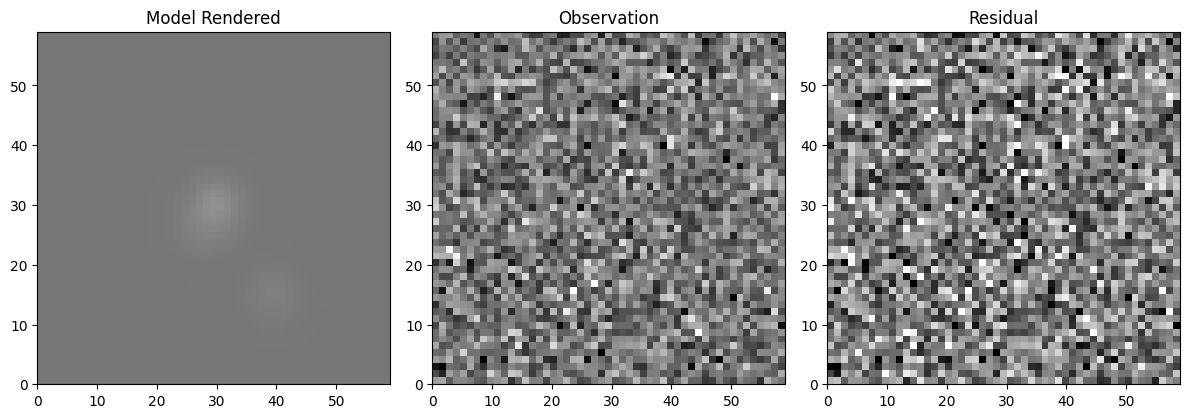

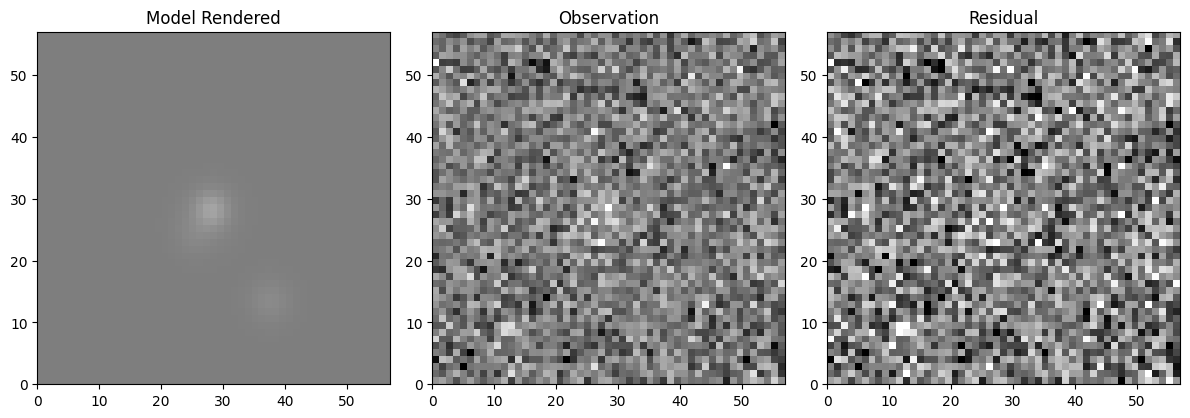

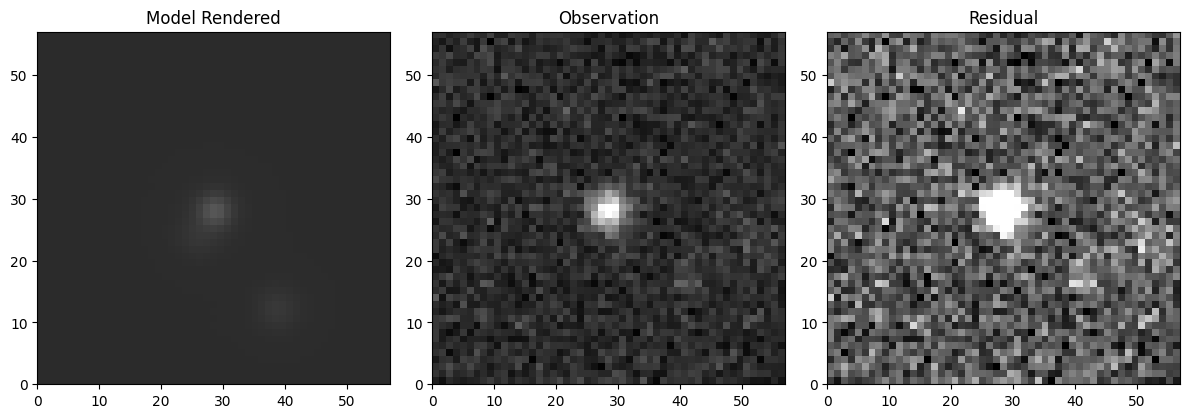

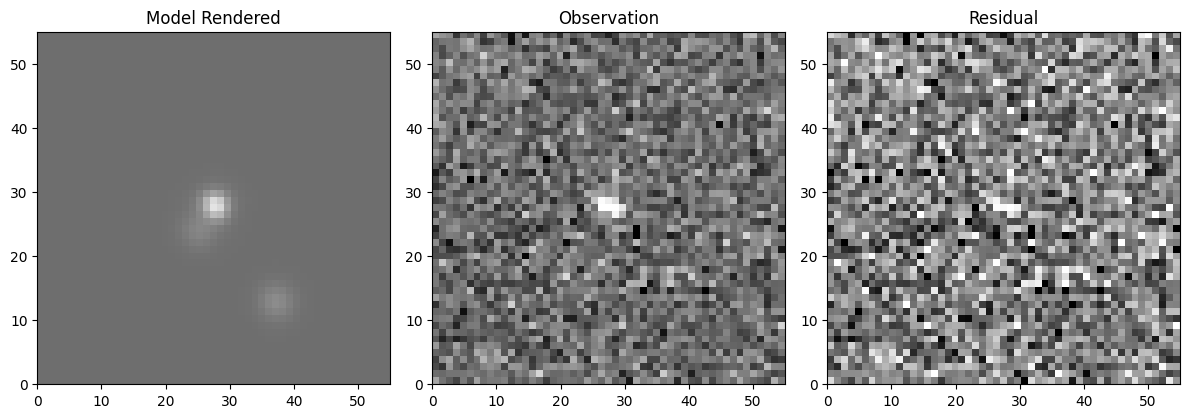

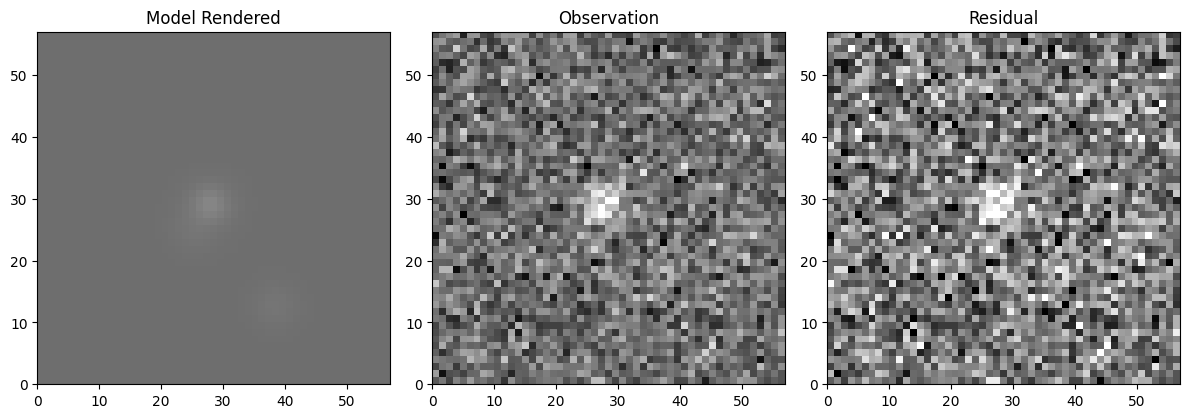

In [19]:
model_psf_s = scarlet.GaussianPSF(sigma=0.9)
for i,(chan,obs,obs1,norm) in enumerate(zip(np.asarray(channels)[:5],np.asarray(observations_sc2)[:5],
                                            np.asarray(obssingle)[:5],np.asarray(normsingle)[:5])):
        model_ = obs.render(scene())
        scarlet.display.show_scarlet2_scene(scene.sources,
                           norm=norm,
                           observation=obs,
                           #channel_map = obs.renderer.channel_map,
                           model = model_,
                           frame = scarlet.Frame.from_observations(obs1, 
                                                                   coverage='intersection', 
                                                                   model_psf=model_psf_s),#model_frame_s,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True,
                           figsize=(12,4)
                          )

In [20]:
[scene.sources[i].spectrum.data[0] for i in range(len(scene.sources))]

[Array(444.70667, dtype=float32),
 Array(13.017898, dtype=float32),
 Array(9.502621, dtype=float32)]

In [21]:
#Free up the AGN position parameter so that it can be refitted
n_steps, peak_value_pos = stepnum, 1
schedulepos = optax.cosine_onecycle_schedule(n_steps, peak_value_pos, final_div_factor=1)
pos_step = lambda p: scarlet2.relative_step(p, factor=.3)
flux = scene.sources[indtransient].spectrum.data
scene.set_info('sources.'+str(indtransient)+'.morphology.center', fixed=False,stepsize = pos_step)
#Fit the scene
scene_ = scene.fit(observations_sc2, max_iter=stepnum, e_rel=1e-6, schedule=schedulepos)

100%|██████████| 500/500 [22:37<00:00,  2.71s/it, loss=37193.25, max_change=0.000024]


In [22]:
[scene_.sources[i].spectrum.data for i in range(len(scene_.sources))]

[Array([  86.00917 ,  796.1045  , 2644.207   ,  659.82794 , 2618.9287  ,
        1325.044   ,  533.9978  ,  585.2833  ,   60.3779  ,   30.577938],      dtype=float32),
 Array([ 4.6069827, 16.676712 , 48.749092 , 13.017899 , 13.017899 ,
        13.017899 , 13.017899 , 13.017899 , 13.017899 , 13.017899 ],      dtype=float32),
 Array([ 1.9463385,  9.604487 , 40.62755  ,  9.502621 ,  9.502621 ,
         9.502621 ,  9.502621 ,  9.502621 ,  9.502621 ,  9.502621 ],      dtype=float32)]

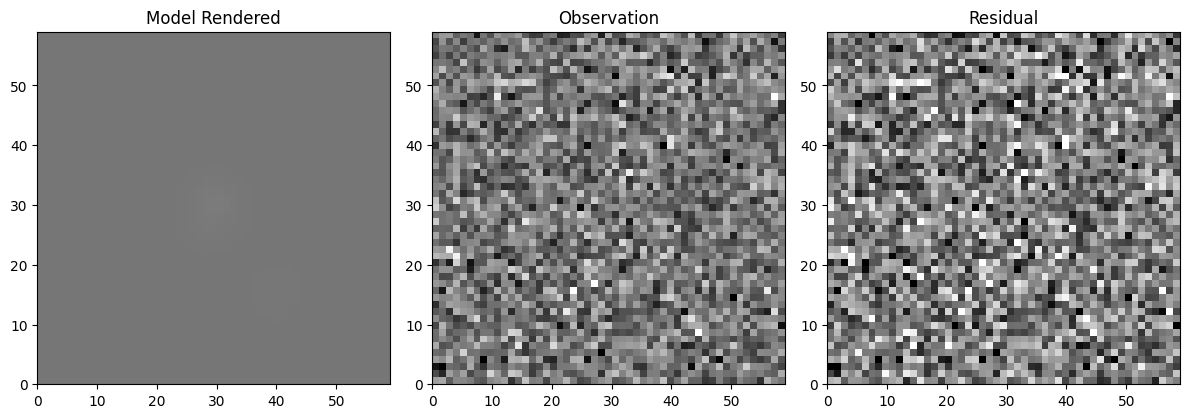

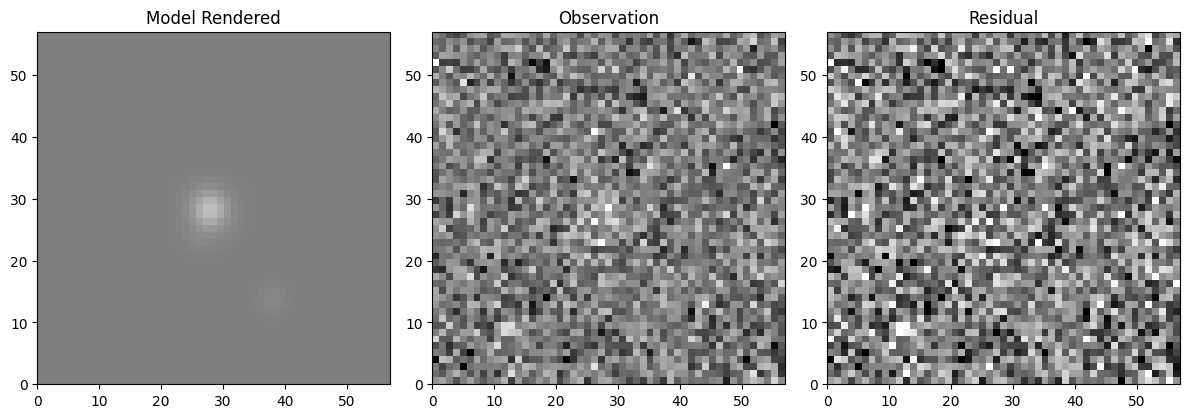

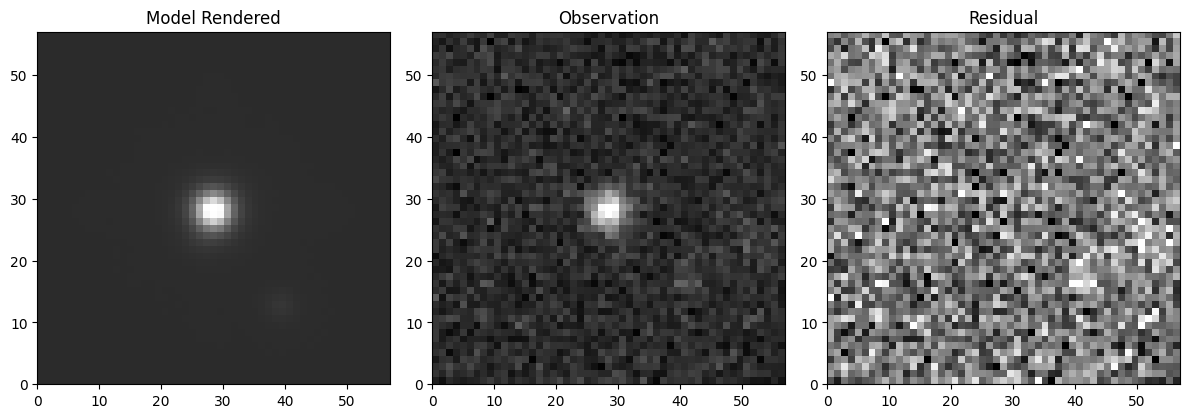

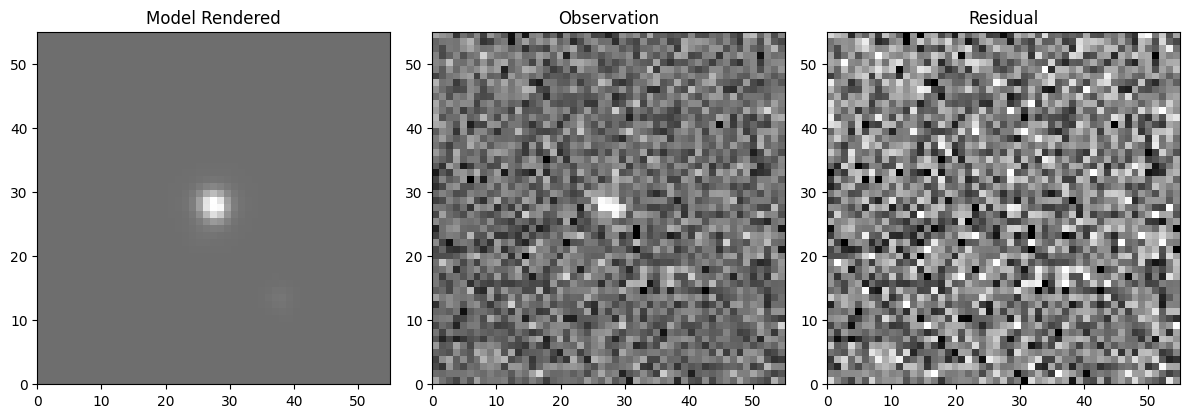

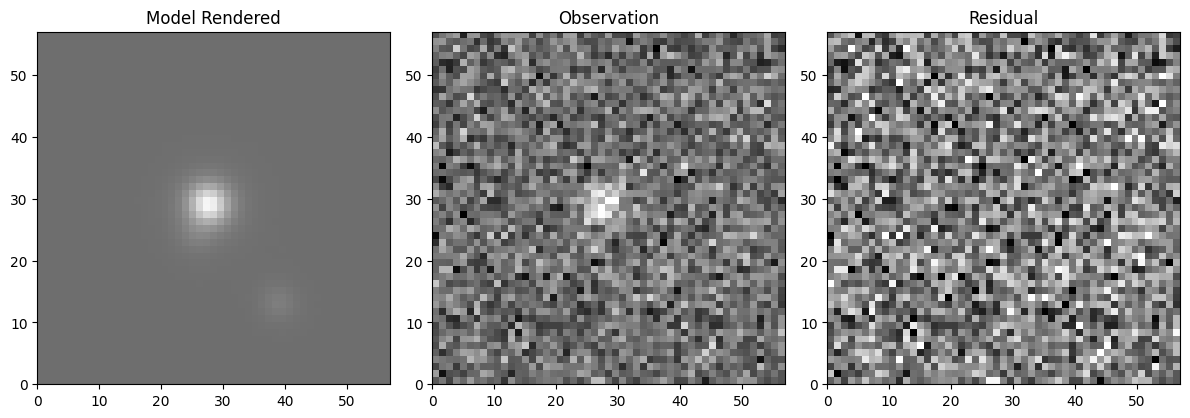

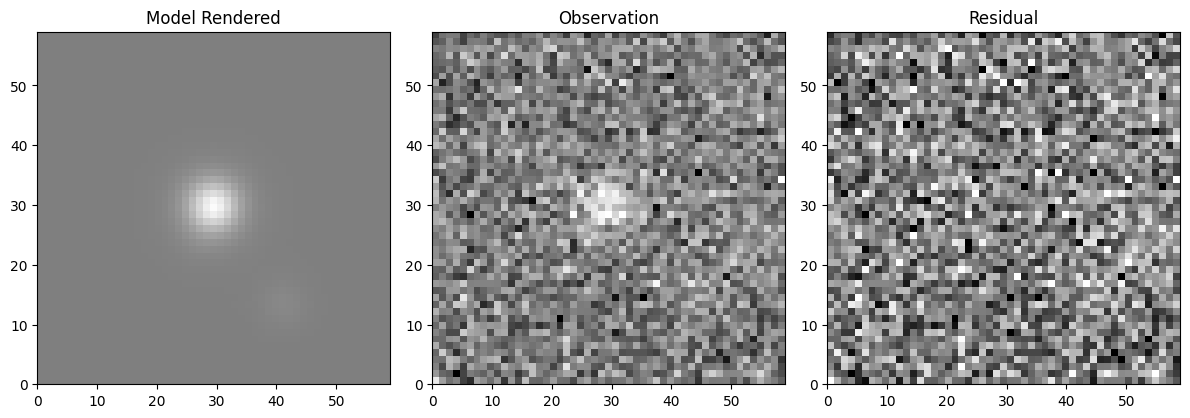

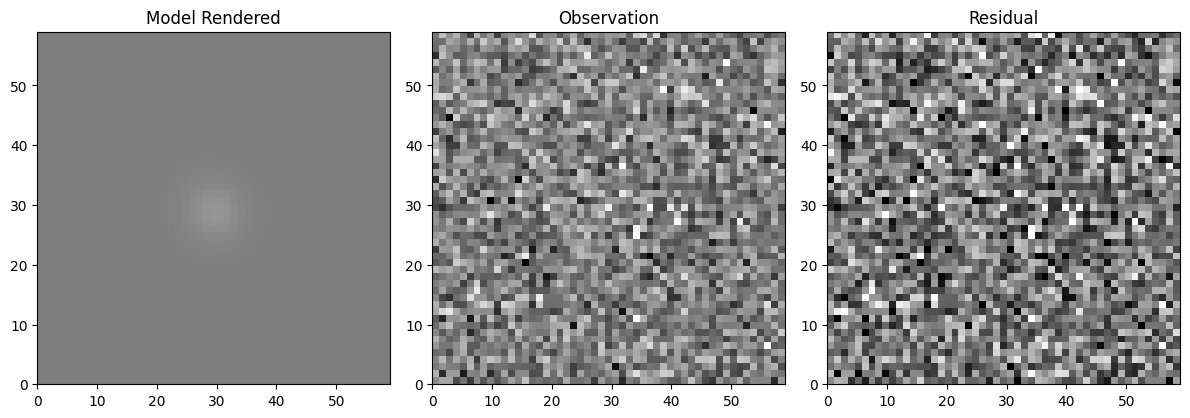

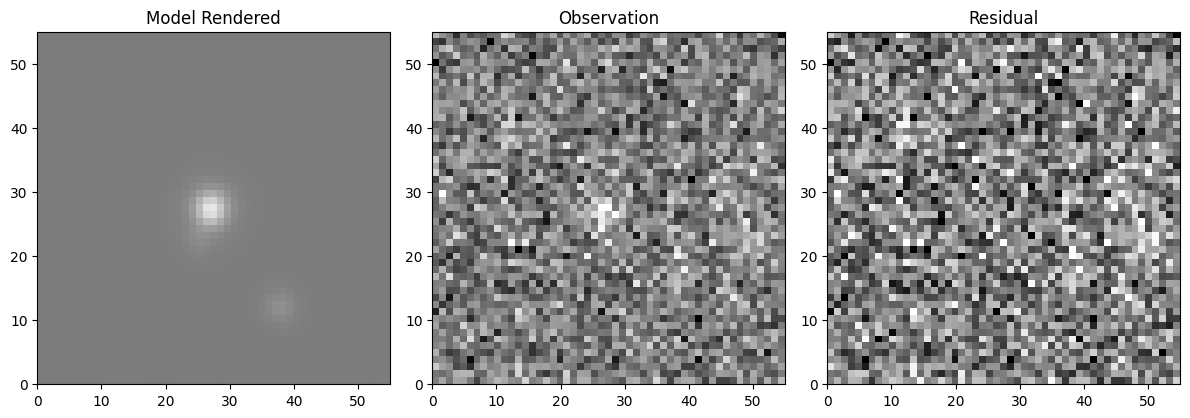

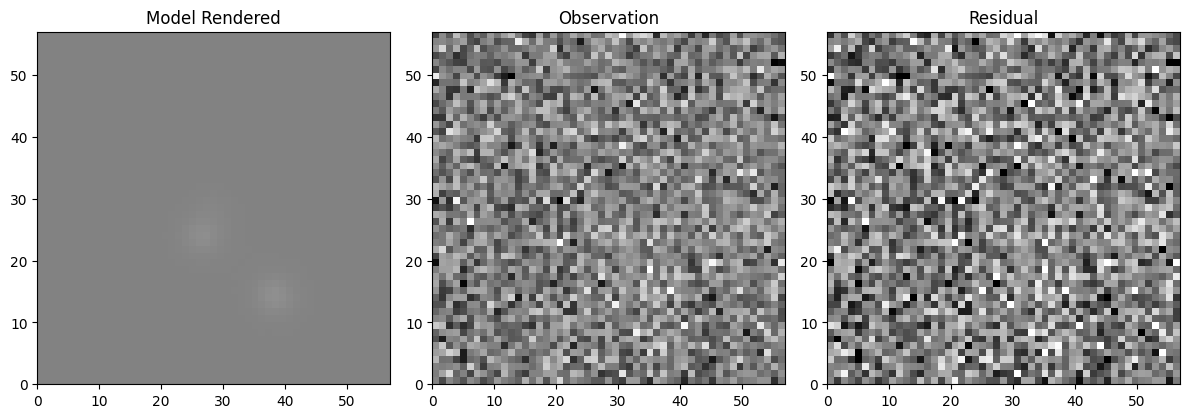

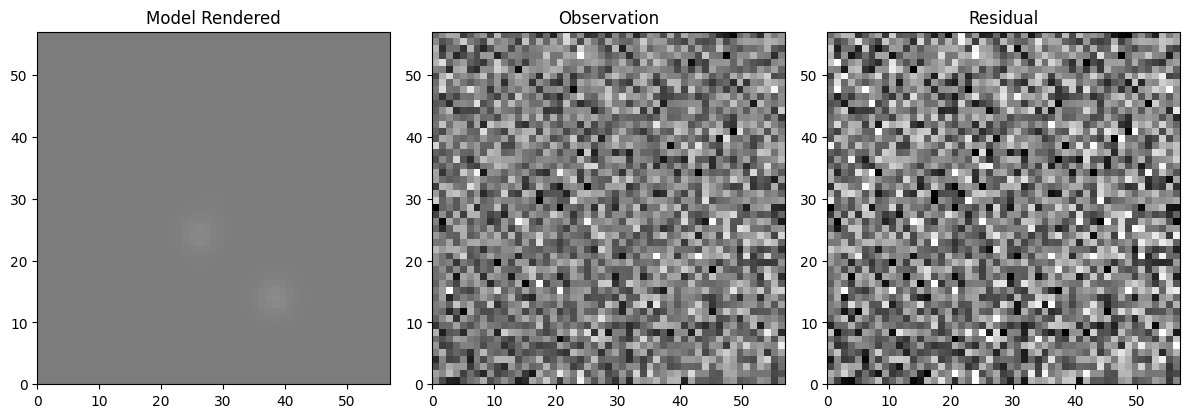

In [23]:
#Plot the models and residuals for the first 10 images
for i,(chan,obs,obs1,norm) in enumerate(zip(channels,
                                                     observations_sc2,
                                                     obssingle,
                                                     normsingle
                                                    )):
        model_ = obs.render(scene_())
        scarlet.display.show_scarlet2_scene(list(scene_.sources),
                           norm=norm,
                           observation=obs,
                           #channel_map = obs.renderer.channel_map,
                           model = model_,
                           frame = scarlet.Frame.from_observations(obs1, 
                                                                   coverage='intersection', 
                                                                   model_psf=model_psf_s),#model_frame_s,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True,
                           figsize=(12,4)
                          )

/tmp/ipykernel_28774/2015753310.py:11: RuntimeWarning: divide by zero encountered in log
  ax.imshow(np.log(y), cmap = cmap,interpolation=int_method,
/tmp/ipykernel_28774/2015753310.py:12: RuntimeWarning: divide by zero encountered in log
  vmin = np.max([np.min(np.log(y)[np.log(y)>-15]),-15]))


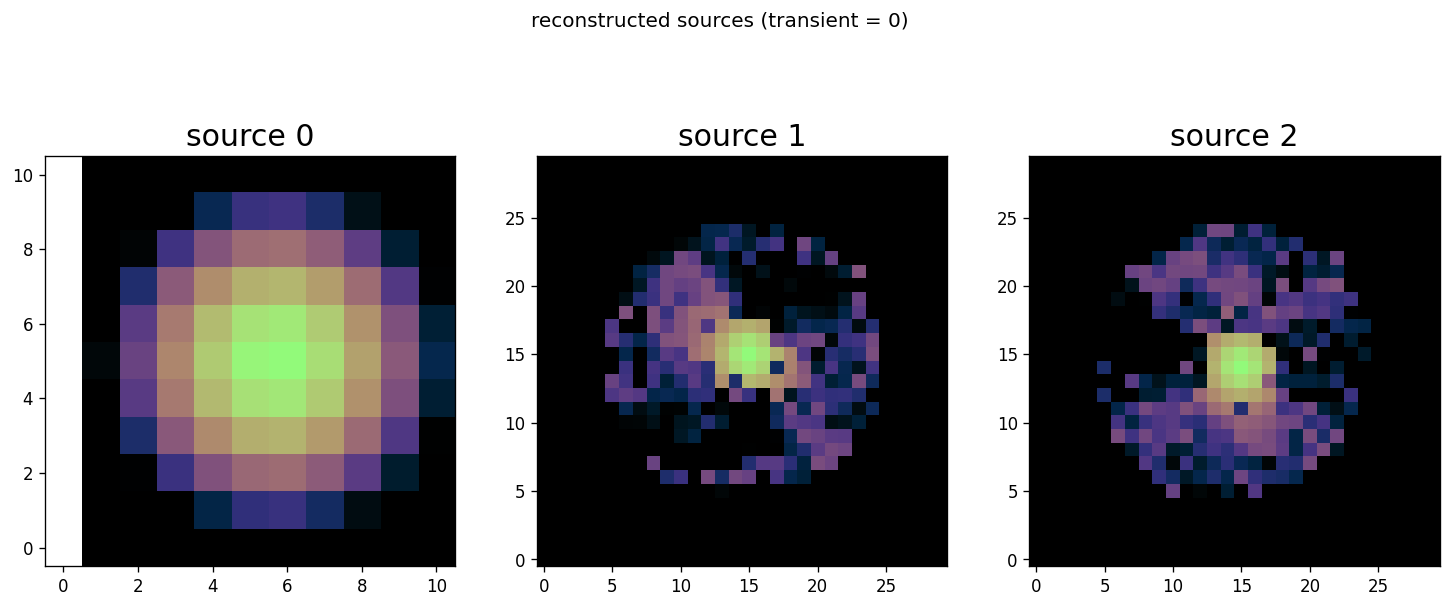

<Figure size 640x480 with 0 Axes>

In [24]:
#Show the point source and host galaxy models
import cmasher as cmr
cmap = cmr.lilac
int_method='none'
fig, axes = plt.subplots(1, len( scene_.sources ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    if i==indtransient:
        y = scene_.sources[i].morphology()
    else:
        y = scene_.sources[i].morphology.data
    ax.imshow(np.log(y), cmap = cmap,interpolation=int_method,
              vmin = np.max([np.min(np.log(y)[np.log(y)>-15]),-15]))
    ax.set_title(f"source {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('reconstructed sources (transient = '+str(indtransient)+')', fontsize=12)#,y=0.75)
# plt.savefig(plotdir+'/'+srcname+'_reconstructed_sources.png')
plt.show()
plt.clf()

In [25]:
phot = db.Photometry.get_for_obj(obj.name)
phot_data = {}
zp0 = {'g': 28.703, 'r': 30.069, 'i': 31.127}
for i in range(len(phot)):
    phot_band = phot[i][1]
    phot_data[i] = pd.DataFrame()
    phot_data[i]['mjd'] = [x.mjd for x in phot_band]
    phot_data[i]['fluxerr'] = [0 for x in phot_band] # CHANGE
    fluxes = []
    for x in phot_band:
        newflux = x.flux*10**((phot_band[0].magzp-x.magzp)/2.5)
        fluxes.append(newflux)
    phot_data[i]['flux'] = fluxes
# phot_data

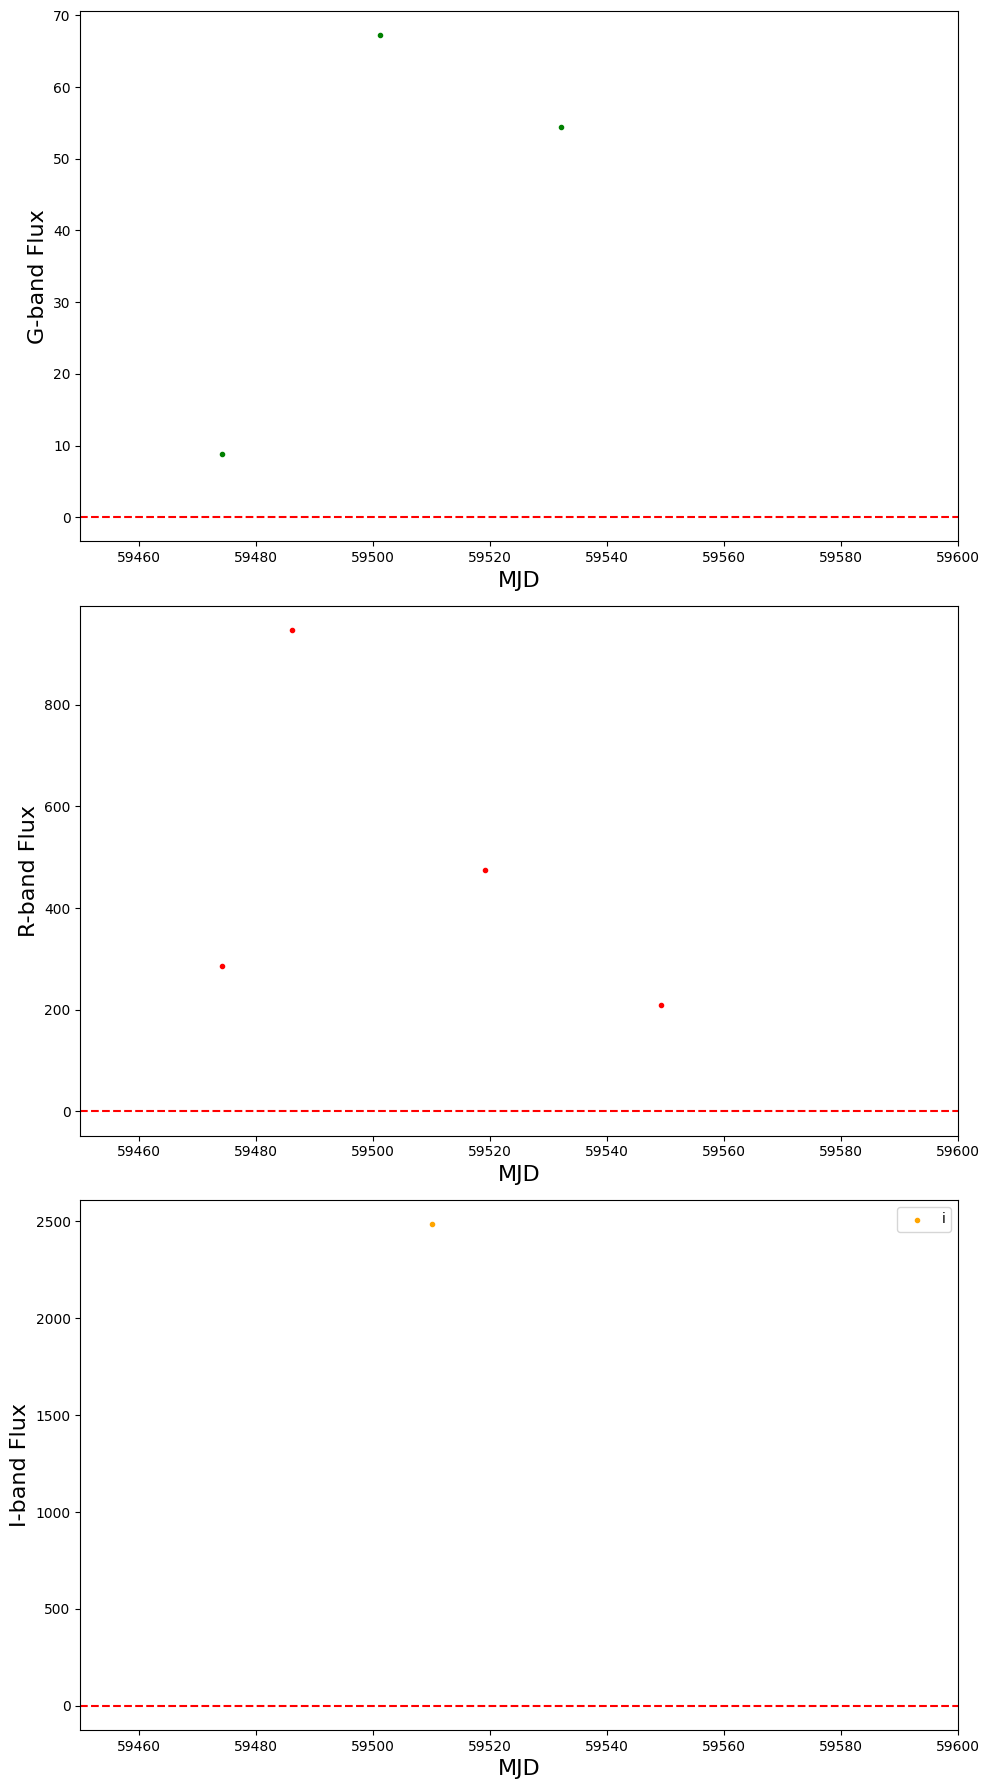

In [26]:
fig, axes = plt.subplots(3,1, figsize=[10,18])

indgal=indtransient+1
zps = np.asfarray(zps)
flux = scene_.sources[indtransient].spectrum.data * np.sum(scene_.sources[indtransient].morphology(),
                                                           axis=(-2,-1)) 
fluxgal = scene_.sources[indgal].spectrum.data * np.sum(scene_.sources[indgal].morphology(),axis=(-2,-1)) 
times=np.asfarray(times)
for bind,(b,c) in enumerate(zip(['g','r','i'],['green','red','orange'])):
        fluxes = flux[epochs==b]
        fluxes = [fluxes[i] * 10**((zp0[b]-zps[i])/2.5) for i in range(len(fluxes))]
        axes[bind].scatter(times[epochs==b],fluxes,
                    label=b,color=c,marker='.')
        # testdata = pd.DataFrame({'mjd': times[epochs==b], 'flux': flux[epochs==b]})
        # testdata.to_csv(f"{data_dir}/{obj_name}_{b}band.dat", index=False)
        # axes[bind].scatter(phot_data[bind].mjd, phot_data[bind].flux, color='b', 
        #                    label='Ap Phot', marker='.')
        # axes[bind].invert_yaxis()
        axes[bind].set_xlim([59450, 59600])
        # axes[bind].set_ylim([-500, 2500])
        axes[bind].plot([59450, 59600], [0, 0], 'r--')
        axes[bind].set_ylabel(f"{b.upper()}-band Flux", fontsize=16)
        axes[bind].set_xlabel("MJD", fontsize=16)
# plt.xlabel('MJD-57700')
# plt.suptitle(f"{obj_name} light curves", fontsize=20)
plt.tight_layout()
plt.legend()
plt.savefig(f"figs/{obj_name}_lc_sample1.png", bbox_inches='tight')
plt.show()

In [ ]:
# ### Cut PSFs to size
# min_psf = 150
# for i,basename in enumerate(basenames):
#     img_file = decam.local_path_from_basename(basename)
#     psf_file = str(img_file)[:-5] + ".psf"
    
#     with fits.open(img_file, memmap=True) as file:
#         img_wcs = WCS(file[0].header)
#         x, y = img_wcs.world_to_pixel(sc)
    
#     # Open PSF file
#     try:
#         reader = PSFExReader(psf_file)
#         ### TODO: Figure out whether this should be shifted or not
#         psf = reader.getclip(x, y, flux=1)
#         if psf.shape[0] < min_psf:
#             min_psf = psf.shape[0]
#     except Exception as e:
#         print(f"\nFile {psf_file}:\n{e}\n")
#         continue
# min_psf

In [11]:
ra_dec = []
obssingle=[]
observations_sc2_old=[]
channels=[]
channels_sc2 =[]
times=[]
zps =[]
tiny=1e-5

# # ra_dec = [sc]
# img_file = decam.local_path_from_basename(basenames[0])
# with fits.open(img_file) as file:
#     wcs0 = WCS(file[0].header)

for i,basename in enumerate(basenames):
    
    # Get file names
    img_file = decam.local_path_from_basename(basename)
    mask_file = decam.local_path_from_basename(basename, filetype='mask')
    weight_file = decam.local_path_from_basename(basename, filetype='weight')
    psf_file = str(img_file)[:-5] + ".psf"
    print(psf_file)
    
    # Open image file
    with fits.open(img_file, memmap=True) as file:
        img_data = file[0].data
        img_hdr = file[0].header
        img_wcs = WCS(file[0].header)
        x, y = img_wcs.world_to_pixel(sc)
    # Make a clip of the image
    med = np.median(img_data)
    clip = Cutout2D(img_data, sc, size=101, wcs=img_wcs, mode='partial', fill_value=med)
    
    # Open weight file
    with fits.open(weight_file, memmap=True) as file:
        weight_data = file[0].data
    clip_weight = Cutout2D(weight_data, sc, size=101, wcs=img_wcs, mode='partial', fill_value=0)
    
    # Open mask file
    with fits.open(mask_file, memmap=True) as file:
        mask_data = file[0].data
    clip_mask = Cutout2D(mask_data, sc, size=101, wcs=img_wcs, mode='partial', fill_value=1)
    
    # Open PSF file
    try:
        reader = PSFExReader(psf_file)
        ### TODO: Figure out whether this should be shifted or not
        psf = reader.getclip(x, y, flux=1)
        
    except Exception as e:
        print(f"\nFile {psf_file}:\n{e}\n")
        continue
    
    ### TODO: mask the images
    
    # Get filter and maglimit
    f = decam.filter(img_file)[-1]
    try:
        maglim = img_hdr['PHOTDPTH']
    except:
        maglim = img_hdr['LMT_MG']
    
    # Get Channel names
    channel, channel_sc2 = [f"{f}{i}"], (f, str(i))
    channels.append(channel)
    channels_sc2.append(channel_sc2)
    
    # Format weight data
    Nw1, Nw2 = clip_weight.data.shape
    weight = clip_weight.data.reshape(1, Nw1, Nw2).astype(float)
    print(weight.shape)
    # weight[np.isnan(data)] = 0
    if (np.sum(weight==0)>0.01*weight.shape[-2]*weight.shape[-1] 
        or maglim<20):#0.001)*weight_ztf.shape[-2]*weight_ztf.shape[-1]:
        print(f'Poor image at index {i}, skipping')
        continue
    
    # Append relevant info
    times.append(img_hdr['MJD-OBS'])
    zps.append(img_hdr['MAGZERO'])
    
    # Format image data
    N1, N2 = clip.data.shape
    data = clip.data.reshape(1, N1, N2).astype(float)
    if np.isnan(data).any():
        print("Panic!")
    data[np.isnan(data)] = 0
    weight[np.isnan(data)] = 0
    print(data.shape)
    
    # Format PSF data
    # if not psf.shape[0]==min_psf:
    #     cut_idx = int((psf.shape[0]-min_psf)/2) # cut to min shape
    #     psf = psf[cut_idx:-cut_idx, cut_idx:-cut_idx]
    psf_data = psf.astype(float)
    Np1, Np2 = psf_data.shape
    psf = scarlet.ImagePSF(psf_data.astype(float))
    print(psf_data.shape)
    
    # Create the scarlet1 observation object and add it to our list of observations
    wcs = clip.wcs
    # wcs = wcs0
    obs = scarlet.Observation(data,
        wcs=wcs,
        psf=psf,
        channels=channel,
        weights=weight)
    obssingle.append(obs)
    

    # Create the scarlet2 observation object and add it to our list of observations
    obs_sc2 = scarlet2.Observation(jnp.asarray(data), 
                                   jnp.asarray(weight), 
                                    psf=scarlet2.ArrayPSF(jnp.asarray(psf_data)),
                                   channels=[channel_sc2], wcs=wcs)
    observations_sc2_old.append(obs_sc2)

print('There are',len(obssingle),'observations')

/pscratch/sd/e/eramey16/data/curveball/DECam_Reduced/2021-09-17/c4d_20210917_030321_g_v1.24.psf


[2024-04-08 16:40:45,916 - WARNING] - Stampwid came out even (56), subtracting 
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(1, 101, 101)
(1, 101, 101)
(25, 25)
/pscratch/sd/e/eramey16/data/curveball/DECam_Reduced/2021-09-17/c4d_20210917_030450_r_v1.24.psf


[2024-04-08 16:40:47,052 - WARNING] - Stampwid came out even (38), subtracting 


(1, 101, 101)
(1, 101, 101)
(25, 25)
/pscratch/sd/e/eramey16/data/curveball/DECam_Reduced/2021-09-29/c4d_20210929_052613_r_v1.24.psf
(1, 101, 101)
(1, 101, 101)
(25, 25)
/pscratch/sd/e/eramey16/data/curveball/DECam_Reduced/2021-10-14/c4d_20211014_044640_g_v1.24.psf


[2024-04-08 16:40:47,451 - WARNING] - Stampwid came out even (28), subtracting 


(1, 101, 101)
(1, 101, 101)
(25, 25)
/pscratch/sd/e/eramey16/data/curveball/DECam_Reduced/2021-10-23/c4d_20211023_032710_i_v1.24.psf


[2024-04-08 16:40:47,729 - WARNING] - Stampwid came out even (44), subtracting 


(1, 101, 101)
(1, 101, 101)
(25, 25)
/pscratch/sd/e/eramey16/data/curveball/DECam_Reduced/2021-11-01/c4d_20211101_051805_r_v1.24.psf
(1, 101, 101)
(1, 101, 101)
(25, 25)
/pscratch/sd/e/eramey16/data/curveball/DECam_Reduced/2021-11-14/c4d_20211114_044159_g_v1.24.psf


[2024-04-08 16:40:49,790 - WARNING] - Stampwid came out even (38), subtracting 


(1, 101, 101)
(1, 101, 101)
(25, 25)
/pscratch/sd/e/eramey16/data/curveball/DECam_Reduced/2021-12-01/c4d_20211201_044336_r_v1.24.psf
(1, 101, 101)
(1, 101, 101)
(25, 25)
/pscratch/sd/e/eramey16/data/curveball/DECam_Reduced/2022-10-06/c4d_20221006_032945_i_v1.24.psf
(1, 101, 101)
(1, 101, 101)
(25, 25)
/pscratch/sd/e/eramey16/data/curveball/DECam_Reduced/2022-10-11/c4d_20221011_044641_i_v1.24.psf
(1, 101, 101)
(1, 101, 101)
(25, 25)
There are 10 observations


In [12]:
lvl = 3
wave = 1
#Obtain source catalog and background flux estimation from our makeCatalog function
catalog_single, bgsingle, detectsingle, globalback = makeCatalog(obssingle, lvl, wave)
obssinglearr=np.asarray(obssingle)
bgsinglearr=np.asfarray(bgsingle)
pixel = np.stack((catalog_single['y'], catalog_single['x']), axis=1)
ra_dec = [obs.get_sky_coord(pixel) for obs in obssinglearr]
observations_sc2=[]
normsingle=[]
for ind,(obs,obs2,bg,back) in enumerate(zip(obssingle,observations_sc2_old,bgsingle,globalback)):
    # obs.weights = np.ones(obs.shape) / (bg**2)[:, None, None]
    #Subtract background flux
    obs.data = obs.data-back
    obs_sc2 = scarlet2.Observation(jnp.asarray(obs.data), jnp.asarray(obs.weights),
                                   psf=scarlet2.ArrayPSF(jnp.asarray(obs.psf.get_model())),
                                   channels=[channels_sc2[ind]], wcs=obs.wcs)
    observations_sc2.append(obs_sc2)
    #Store norm based on observation data
    normsingle.append(LinearPercentileNorm(obs.data,percentiles=[0.1, 99.9]))

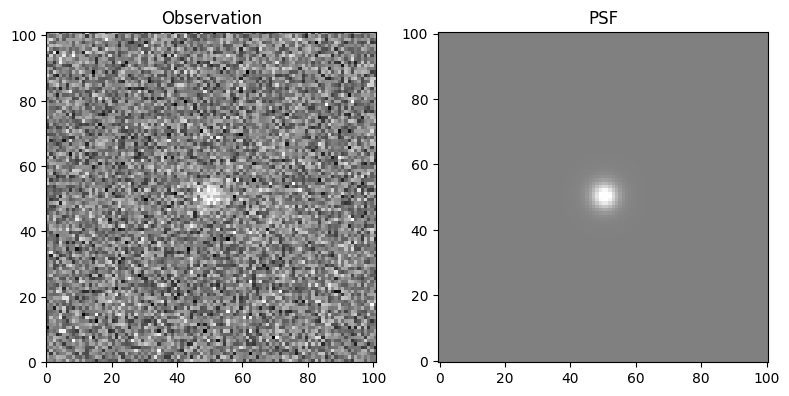

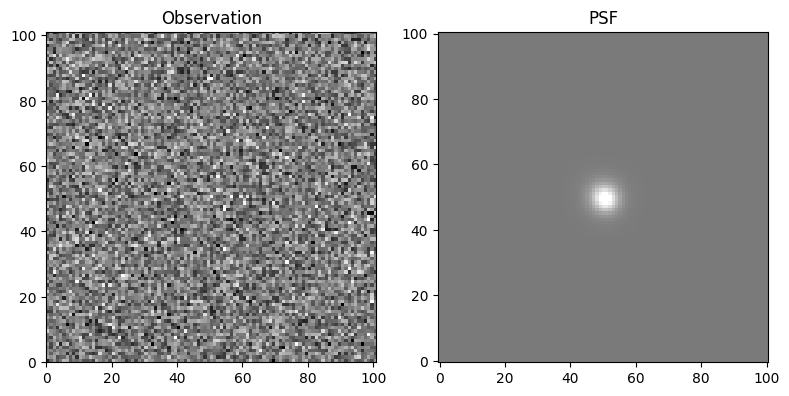

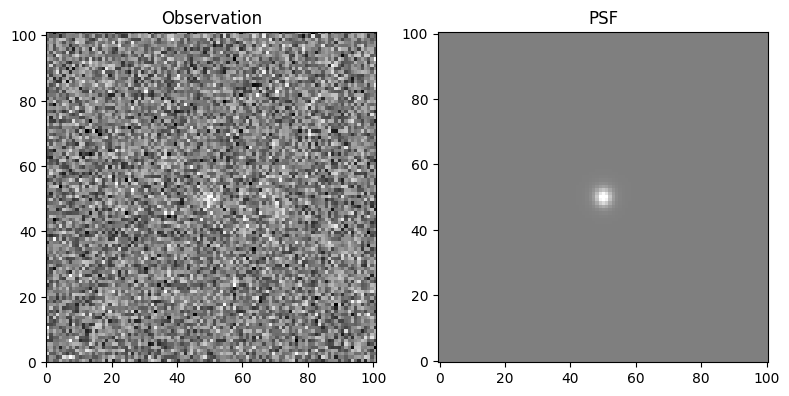

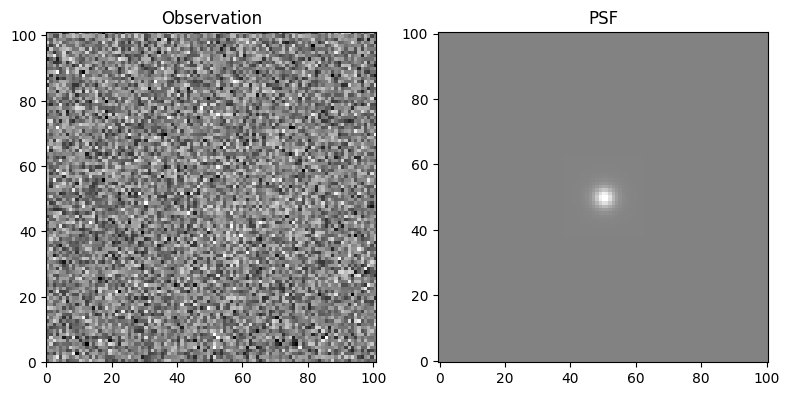

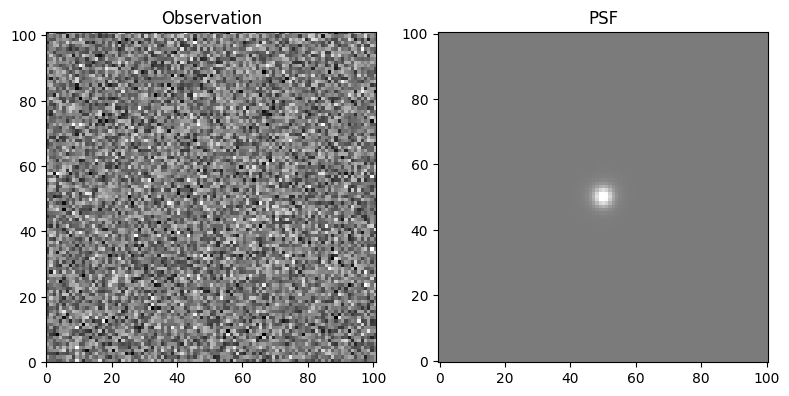

In [13]:
for ind,(obs, norm) in enumerate(zip(obssingle[5:10], normsingle[5:10])):
    scarlet.display.show_observation(obs, norm=norm, sky_coords=ra_dec, 
                                     show_psf=True, add_labels=False)

In [14]:
model_psf_s = scarlet.GaussianPSF(sigma=0.9)
model_frame_s = scarlet.Frame.from_observations([obssingle[0], obssingle[1]], 
                                                coverage='intersection',
                                                model_psf=model_psf_s)
print(model_frame_s)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [18]:
sources = []
if len(ra_dec[0].shape)==1:
    print('Only one source found, initializing in center')
    for ind,sky_coord in enumerate([ra_dec[0]]):
        separ=[0]
        print('Initialization source',ind,'at',sky_coord)
        sources.append(scarlet.PointSource(model_frame_s,
                                sky_coord,
                                obssingle,
                                ))
        sources.append(scarlet.SingleExtendedSource(model_frame_s,
                            sky_coord,
                               obssingle,
                               thresh=0.01,
                               shifting=False,
                               resizing=False,
                               boxsize=50,                     
                              ))
        indtransient=0
else:
    c2 = [SkyCoord(ra*u.deg,dec*u.deg,frame='icrs') for ra,dec in ra_dec[0]]
    separ = [coord_transient.separation(c).arcsecond for c in c2]
    indtransient = np.argmin(separ)
    indgal = np.argmin(separ)
    for ind,sky_coord in enumerate(ra_dec[0]):
        print('Initialization source',ind,'at',sky_coord)
        if ind == indtransient:
            sources.append(scarlet.PointSource(model_frame_s,
                                    sky_coord,
                                    obssingle
                                    ))

            sources.append(scarlet.SingleExtendedSource(model_frame_s,
                                sky_coord,
                                   obssingle,
                                   thresh=0.01,
                                   shifting=False,
                                   resizing=True,
                                   boxsize=50,                     
                                  ))

        else:
            sources.append(scarlet.SingleExtendedSource(model_frame_s,
                                sky_coord,
                                   obssingle,
                                   thresh=0.01,
                                   shifting=False,
                                   resizing=False,
                                   boxsize=50,
                                  ))

Zero or negative spectrum [-558.73134517] at [  8.94907641 -42.72462199]


Only one source found, initializing in center
Initialization source 0 at [  8.94907641 -42.72462199]


AssertionError: 

In [ ]:
epochs = np.asarray([obs.channels[0][0] for obs in obssingle])
bands0,inds0 = np.unique([obs.channels[0][0] for obs in obssingle],return_index=True)

bands = epochs[inds0]
repeats = np.asarray([np.sum([epochs==b]) for b in bands],dtype=int)    
scarlet.initialization.set_spectra_to_match(sources, obssingle)#, repeats=repeats)

In [ ]:
blend = scarlet.Blend(sources, obssingle)

for i in range(len(obssingle[:5])):
    print(obssingle[i].channels)
    scarlet.display.show_scene(sources,
                               norm=normsingle[i],
                               observation=obssingle[i],
                                show_model=False,
                               show_rendered=True,
                               show_observed=True,
                               show_residual=True,
                               figsize=(12,4)
                              )

In [ ]:
it, logL = blend.fit(200, e_rel=1e-6)
print(f"scarlet ran for {it} iterations to logL = {logL}")
scarlet.display.show_likelihood(blend)

In [ ]:
for i in range(5):#len(obssingle)):
    scarlet.display.show_scene(sources,
                               norm=normsingle[i],
                               observation=obssingle[i],
                               show_model=False,
                               show_rendered=True,
                               show_observed=True,
                               show_residual=True,
                               figsize=(12,4)
                              )

### Scarlet 2

In [21]:
frame_psf_sc2 = scarlet2.GaussianPSF(0.9)
model_frame_sc2 = scarlet2.Frame(scarlet2.Box((len(observations_sc2),
                                               observations_sc2[0].data.shape[-2],
                                               observations_sc2[0].data.shape[-1])), 
                                 psf=frame_psf_sc2, 
                                 channels=channels_sc2,
                                 wcs=obssingle[0].wcs)

box_sizes = [s.morphology.bbox.shape for s in sources]
for obs in observations_sc2:
    obs.match(model_frame_sc2)

NameError: name 'sources' is not defined

In [ ]:
morph_init = [None]*(len(sources))
for i,s in enumerate(sources):
    raw = s.morphology.get_model()
    morph_init[i] = (raw-jnp.min(raw))/(jnp.max(raw)-jnp.min(raw))+1e-10

In [25]:
from galaxygrad import ZTF_ScoreNet64
prior_model = ZTF_ScoreNet64

bandall = ['g', 'r', 'i']
# define and data transforms applied to the training data
# transform to training space
# these will be applied to the data before training
# and accounted for in the gradient (i.e. the jacobian is applied)
def transform(x):
    sigma_y = 0.10
    return jnp.log(x + 1) / sigma_y
stepnum=500
from scarlet2 import nn
with scarlet2.Scene(model_frame_sc2) as scene:
    for i,src in enumerate(sources):      
        prior = nn.ScorePrior(model=prior_model, transform=transform, model_size=64) # prior on galaxy morphology
        if i==indtransient:
            bboxpos = src.morphology.bbox.center
            diff = src.center - list(bboxpos)[1:2]
            pos = np.asfarray([src.center[0]-2,src.center[1]-2])
            flux = src.spectrum.get_model()
            flux[flux<0.1*np.median(flux)] = np.median(flux)
            n_steps, peak_value2 = stepnum, jnp.max(flux[~np.isinf(flux)])
            print(peak_value2)
            schedule3 = optax.cosine_onecycle_schedule(n_steps, peak_value2, final_div_factor=1)
            AGN_step = lambda p: scarlet2.relative_step(p, factor=1e-3)
            scarlet2.PointSource(
                    pos,
                    scarlet2.ArraySpectrum(Parameter(jnp.asarray(flux), 
                                                     stepsize=AGN_step, 
                                                     constraint=constraints.positive)) 
                #,constraint = scarlet2.PositiveConstraint())
                )
            
        else:
            pos = np.asfarray([src.morphology.bbox.center[0]-2,
                               src.morphology.bbox.center[1]-2])
            flux = src.spectrum.get_model()[inds0]
            n_steps, peak_value = stepnum, 1#jnp.max(flux)
            schedule = optax.cosine_onecycle_schedule(n_steps, peak_value, final_div_factor=1)
            morph_step = lambda p: scarlet2.relative_step(p, factor=1e-3)
            #lambda p, it: scarlet2.relative_step(p, factor=2e-3) * schedule(it)
            test_step_morph =2e-3*peak_value
            n_steps, peak_value2 = stepnum, 0.1*jnp.max(flux[~np.isinf(flux)])
            print(peak_value2)
            schedule2 = optax.cosine_onecycle_schedule(n_steps, peak_value2, final_div_factor=1)
            gal_step = lambda p: scarlet2.relative_step(p, factor=1e-3)
            scarlet2.Source(
                pos,
                scarlet2.StaticArraySpectrum(Parameter(jnp.asarray(flux), 
                                                       stepsize=gal_step,
                                                       constraint = constraints.positive),
                                             filters=bandall),
                scarlet2.ArrayMorphology(Parameter(morph_init[i], 
                                                   stepsize=morph_step, 
                                                   constraint = constraints.positive, 
                                                   prior=prior)))

3255.9636
27.517313


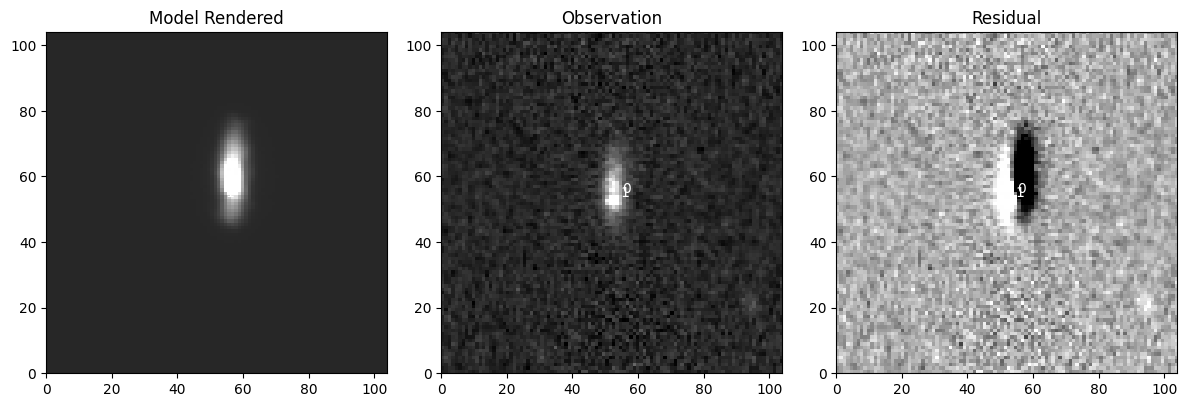

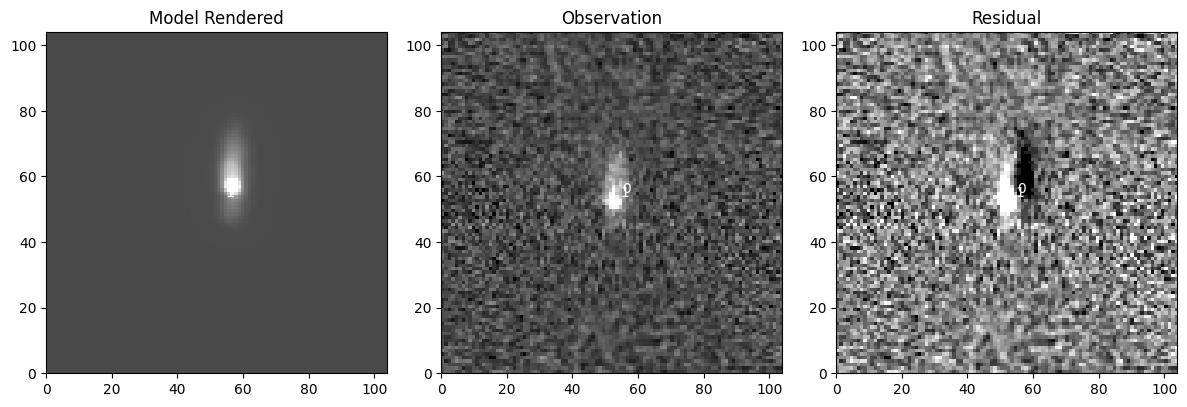

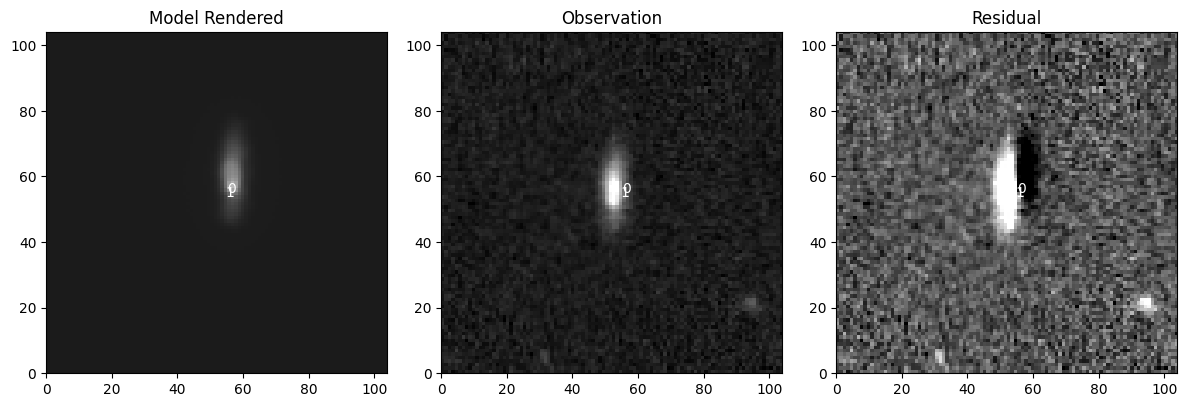

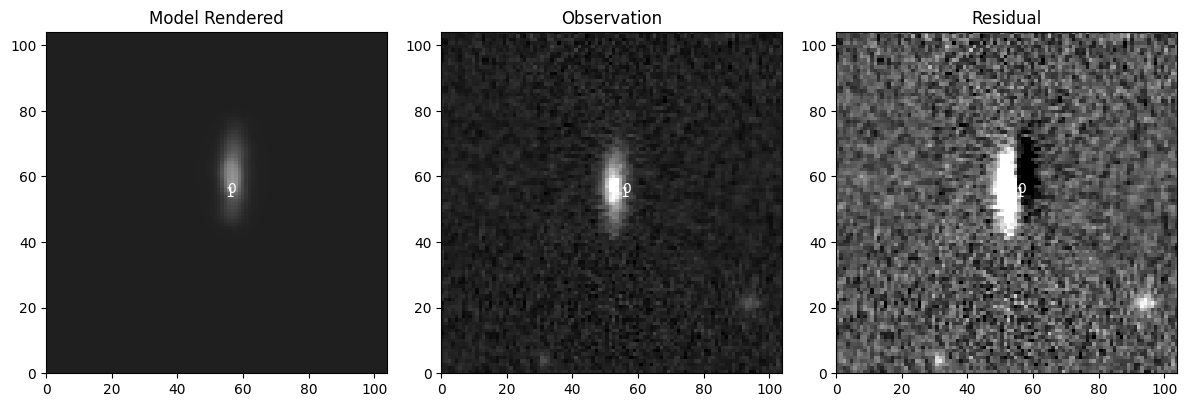

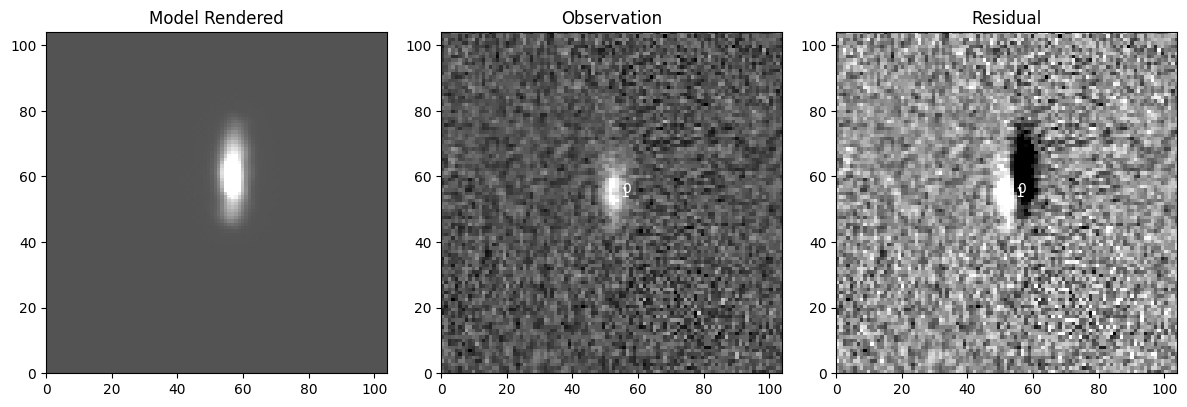

In [26]:
for i,(chan,obs,obs1,norm) in enumerate(zip(np.asarray(channels)[:5],np.asarray(observations_sc2)[:5],
                                            np.asarray(obssingle)[:5],np.asarray(normsingle)[:5])):
        model_ = obs.render(scene())
        scarlet.display.show_scarlet2_scene(sources,
                           norm=norm,
                           observation=obs,
                           #channel_map = obs.renderer.channel_map,
                           model = model_,
                           frame = scarlet.Frame.from_observations(obs1, 
                                                                   coverage='intersection', 
                                                                   model_psf=model_psf_s),#model_frame_s,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True,
                           figsize=(12,4)
                          )

In [27]:
#Free up the AGN position parameter so that it can be refitted
n_steps, peak_value_pos = stepnum, 1
schedulepos = optax.cosine_onecycle_schedule(n_steps, peak_value_pos, final_div_factor=1)
pos_step = lambda p: scarlet2.relative_step(p, factor=.1)
flux = scene.sources[indtransient].spectrum.data
scene.set_info('sources.'+str(indtransient)+'.morphology.center', fixed=False,stepsize = pos_step)
#Fit the scene
scene_ = scene.fit(observations_sc2, max_iter=stepnum, e_rel=1e-6, schedule=schedulepos)

  0%|          | 0/500 [00:00<?, ?it/s]2024-03-15 13:54:47.282818: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit__make_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-03-15 14:27:26.418072: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 34m39.173805309s

********************************
[Compiling module jit__make_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
100%|██████████| 500/500 [55:36<00:00,  6.67s/it, loss=5432172.00, max_change=0.000048]    


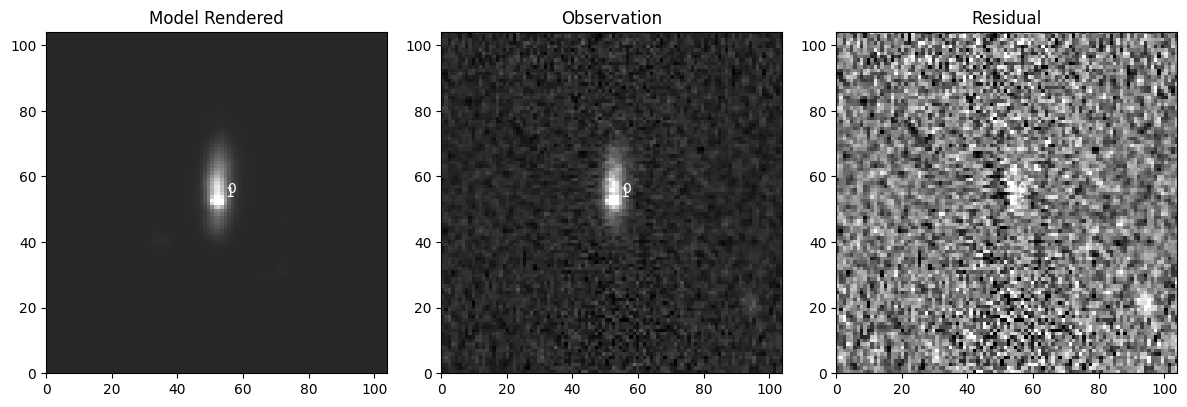

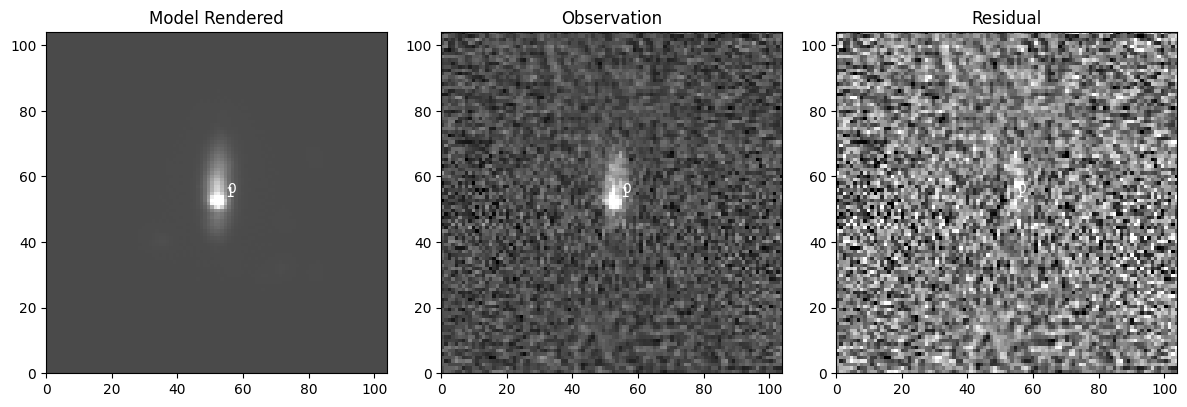

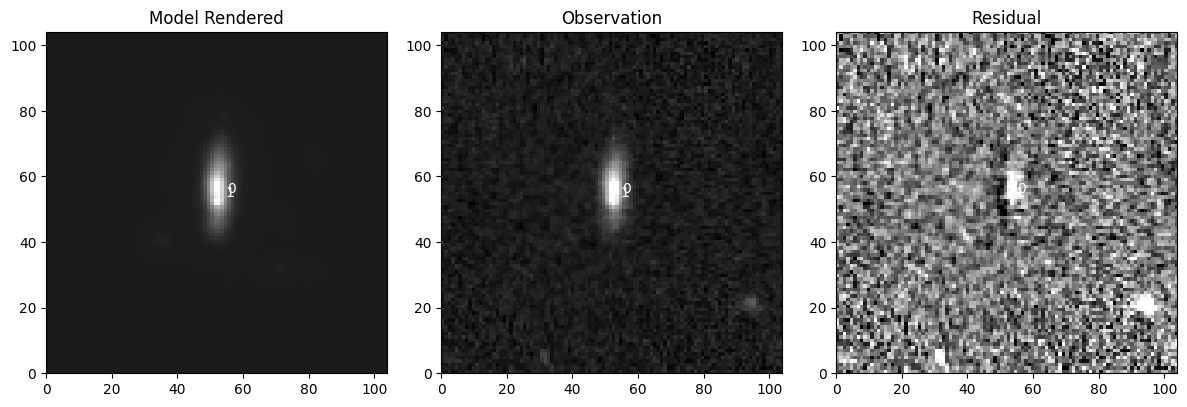

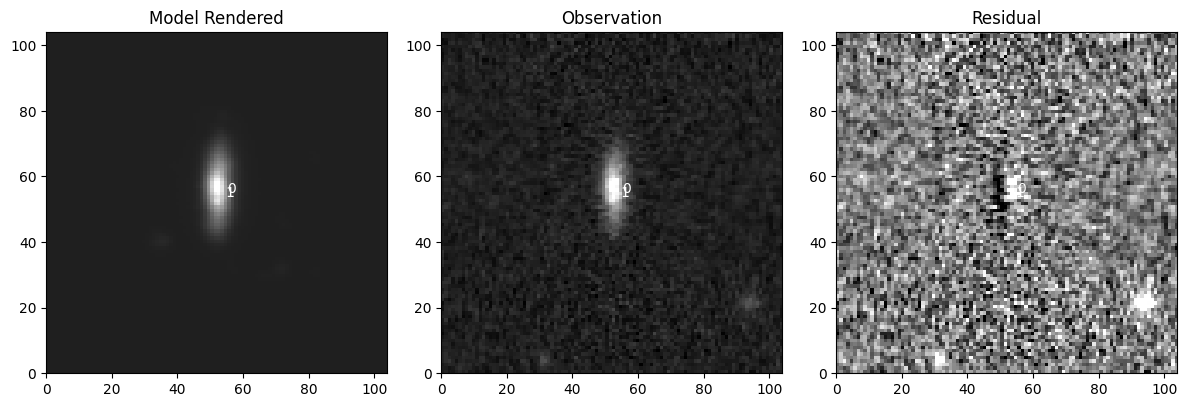

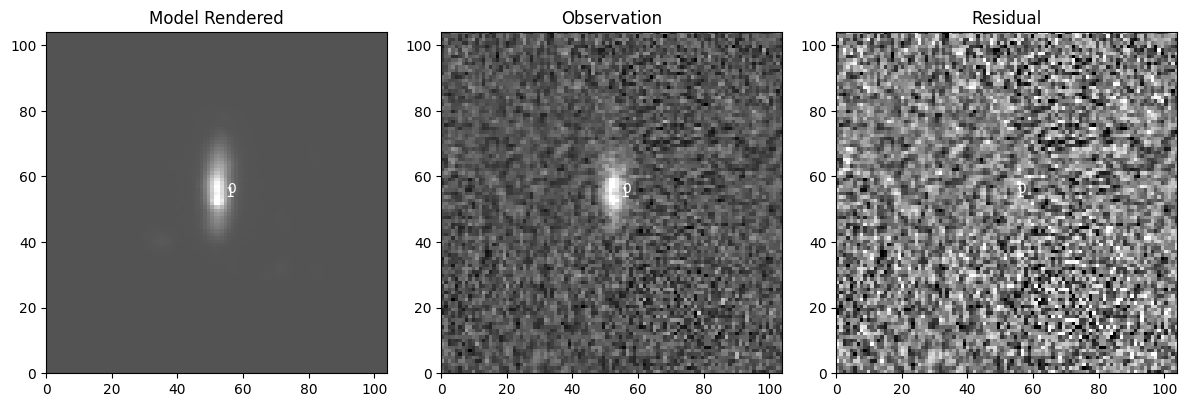

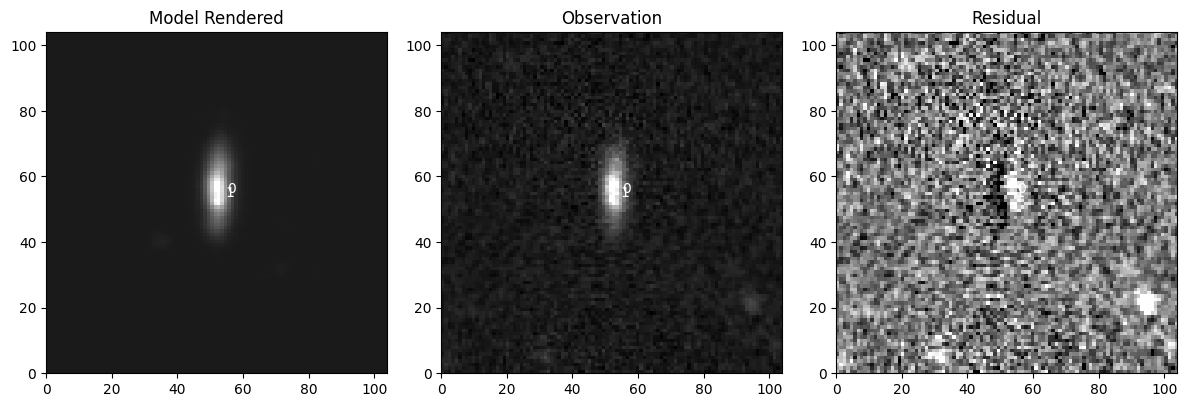

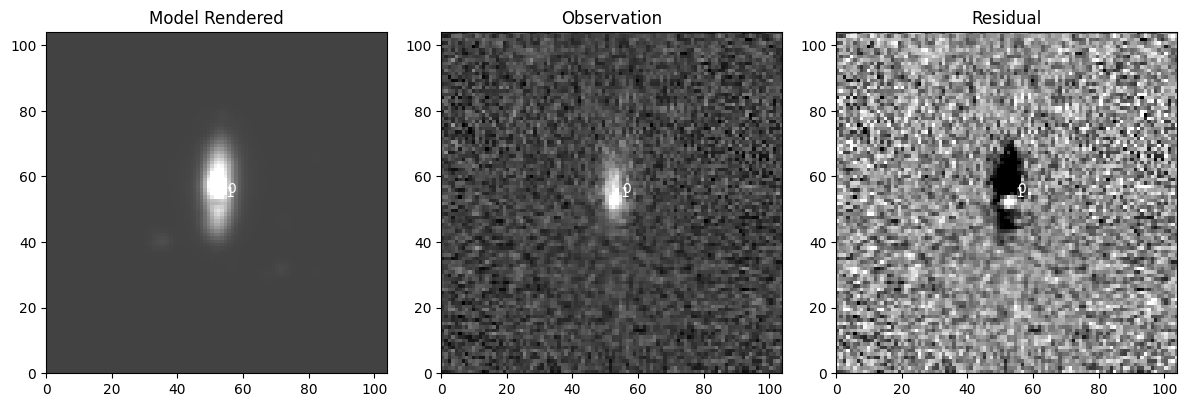

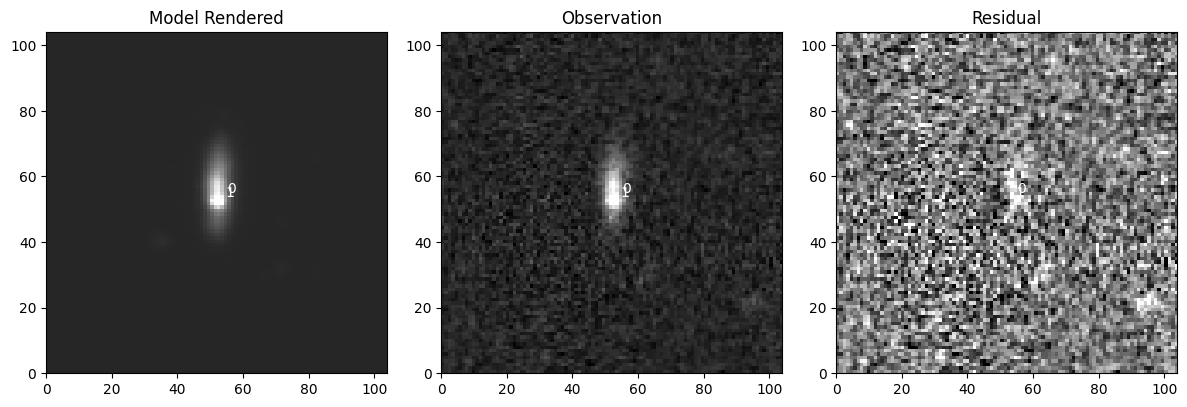

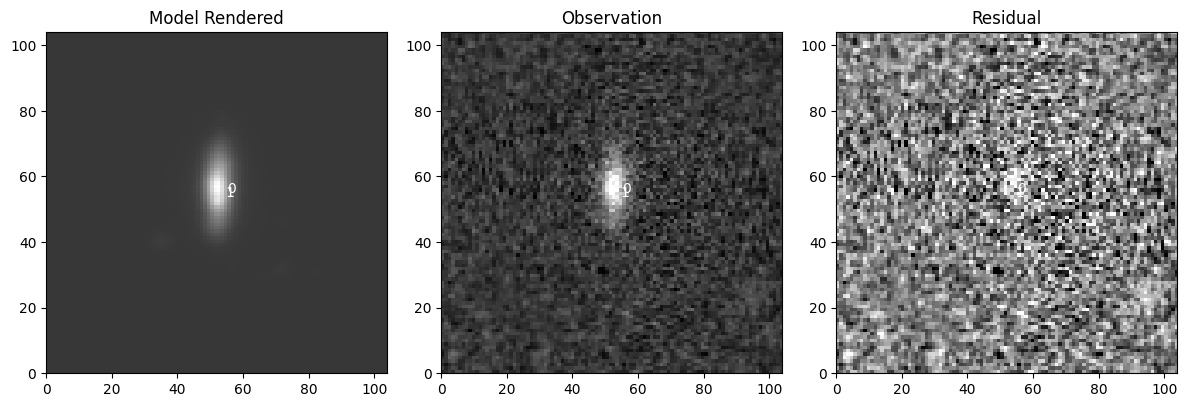

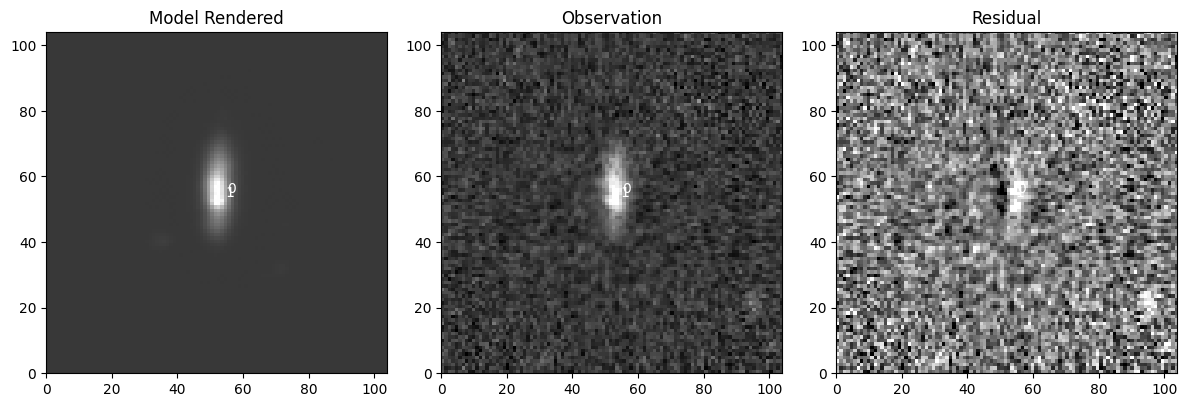

In [28]:
#Plot the models and residuals for the first 10 images
resid_wt = []
for i,(chan,obs,obs1,norm,clipwt) in enumerate(zip(channels[:10],
                                                     observations_sc2[:10],
                                                     obssingle,
                                                     normsingle[:10],
                                                     clipwts[:10]
                                                    )):
        model_ = obs.render(scene_())
        resid_wt.append((obs.data - model_)*np.sqrt(clipwt.data))
        scarlet.display.show_scarlet2_scene(sources,
                           norm=norm,
                           observation=obs,
                           #channel_map = obs.renderer.channel_map,
                           model = model_,
                           frame = scarlet.Frame.from_observations(obs1, 
                                                                   coverage='intersection', 
                                                                   model_psf=model_psf_s),#model_frame_s,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True,
                           figsize=(12,4)
                          )

/tmp/ipykernel_1506494/1571555195.py:11: RuntimeWarning: divide by zero encountered in log
  ax.imshow(np.log(y), cmap = cmap,interpolation=int_method,
/tmp/ipykernel_1506494/1571555195.py:11: RuntimeWarning: invalid value encountered in log
  ax.imshow(np.log(y), cmap = cmap,interpolation=int_method,
/tmp/ipykernel_1506494/1571555195.py:12: RuntimeWarning: divide by zero encountered in log
  vmin = np.max([np.min(np.log(y)[np.log(y)>-15]),-15]))
/tmp/ipykernel_1506494/1571555195.py:12: RuntimeWarning: invalid value encountered in log
  vmin = np.max([np.min(np.log(y)[np.log(y)>-15]),-15]))


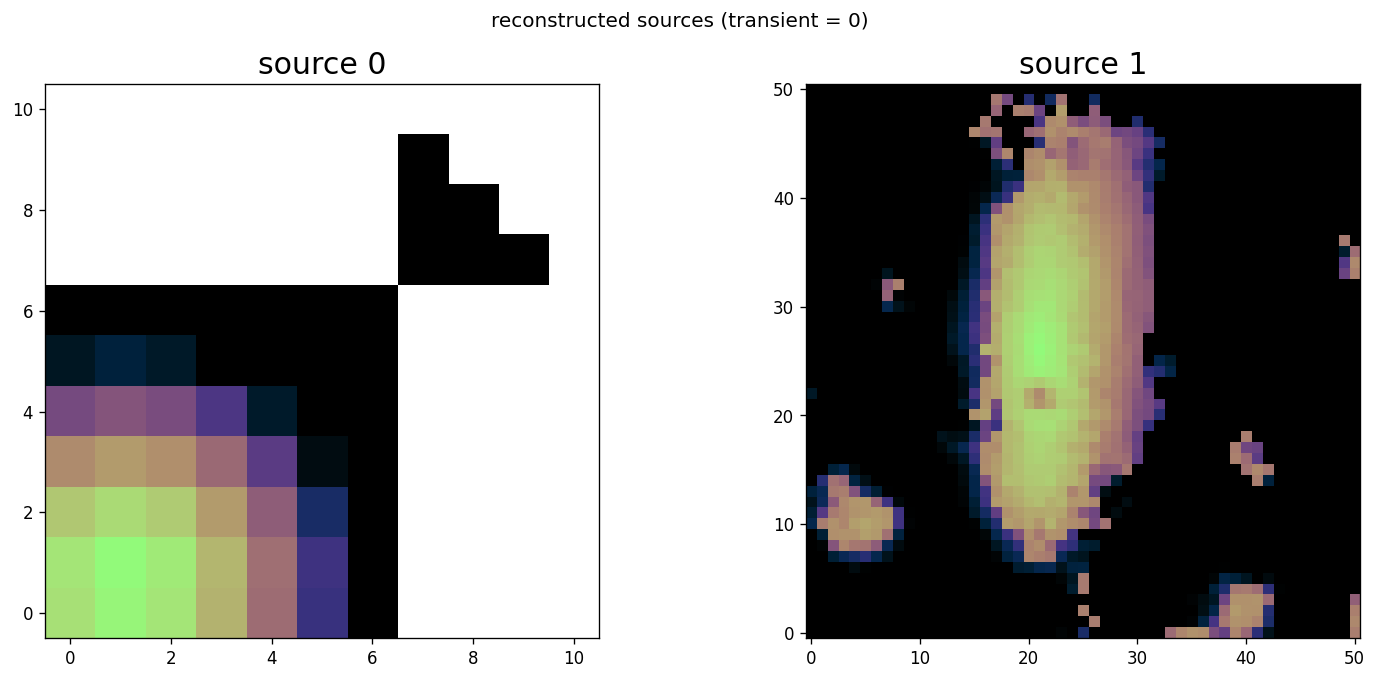

<Figure size 640x480 with 0 Axes>

In [29]:
#Show the point source and host galaxy models
import cmasher as cmr
cmap = cmr.lilac
int_method='none'
fig, axes = plt.subplots(1, len( scene.sources ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    if i==indtransient:
        y = scene_.sources[i].morphology()
    else:
        y = scene_.sources[i].morphology.data
    ax.imshow(np.log(y), cmap = cmap,interpolation=int_method,
              vmin = np.max([np.min(np.log(y)[np.log(y)>-15]),-15]))
    ax.set_title(f"source {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('reconstructed sources (transient = '+str(indtransient)+')', fontsize=12)#,y=0.75)
# plt.savefig(plotdir+'/'+srcname+'_reconstructed_sources.png')
plt.show()
plt.clf()

In [30]:
phot = db.Photometry.get_for_obj('DC21cozcn')
phot_data = {}
zp0 = {'g': 28.703, 'r': 30.069, 'i': 31.127}
for i in range(len(phot)):
    phot_band = phot[i][1]
    phot_data[i] = pd.DataFrame()
    phot_data[i]['mjd'] = [x.mjd for x in phot_band]
    phot_data[i]['fluxerr'] = [0 for x in phot_band] # CHANGE
    fluxes = []
    for x in phot_band:
        newflux = x.flux*10**((phot_band[0].magzp-x.magzp)/2.5)
        fluxes.append(newflux)
    phot_data[i]['flux'] = fluxes
# phot_data

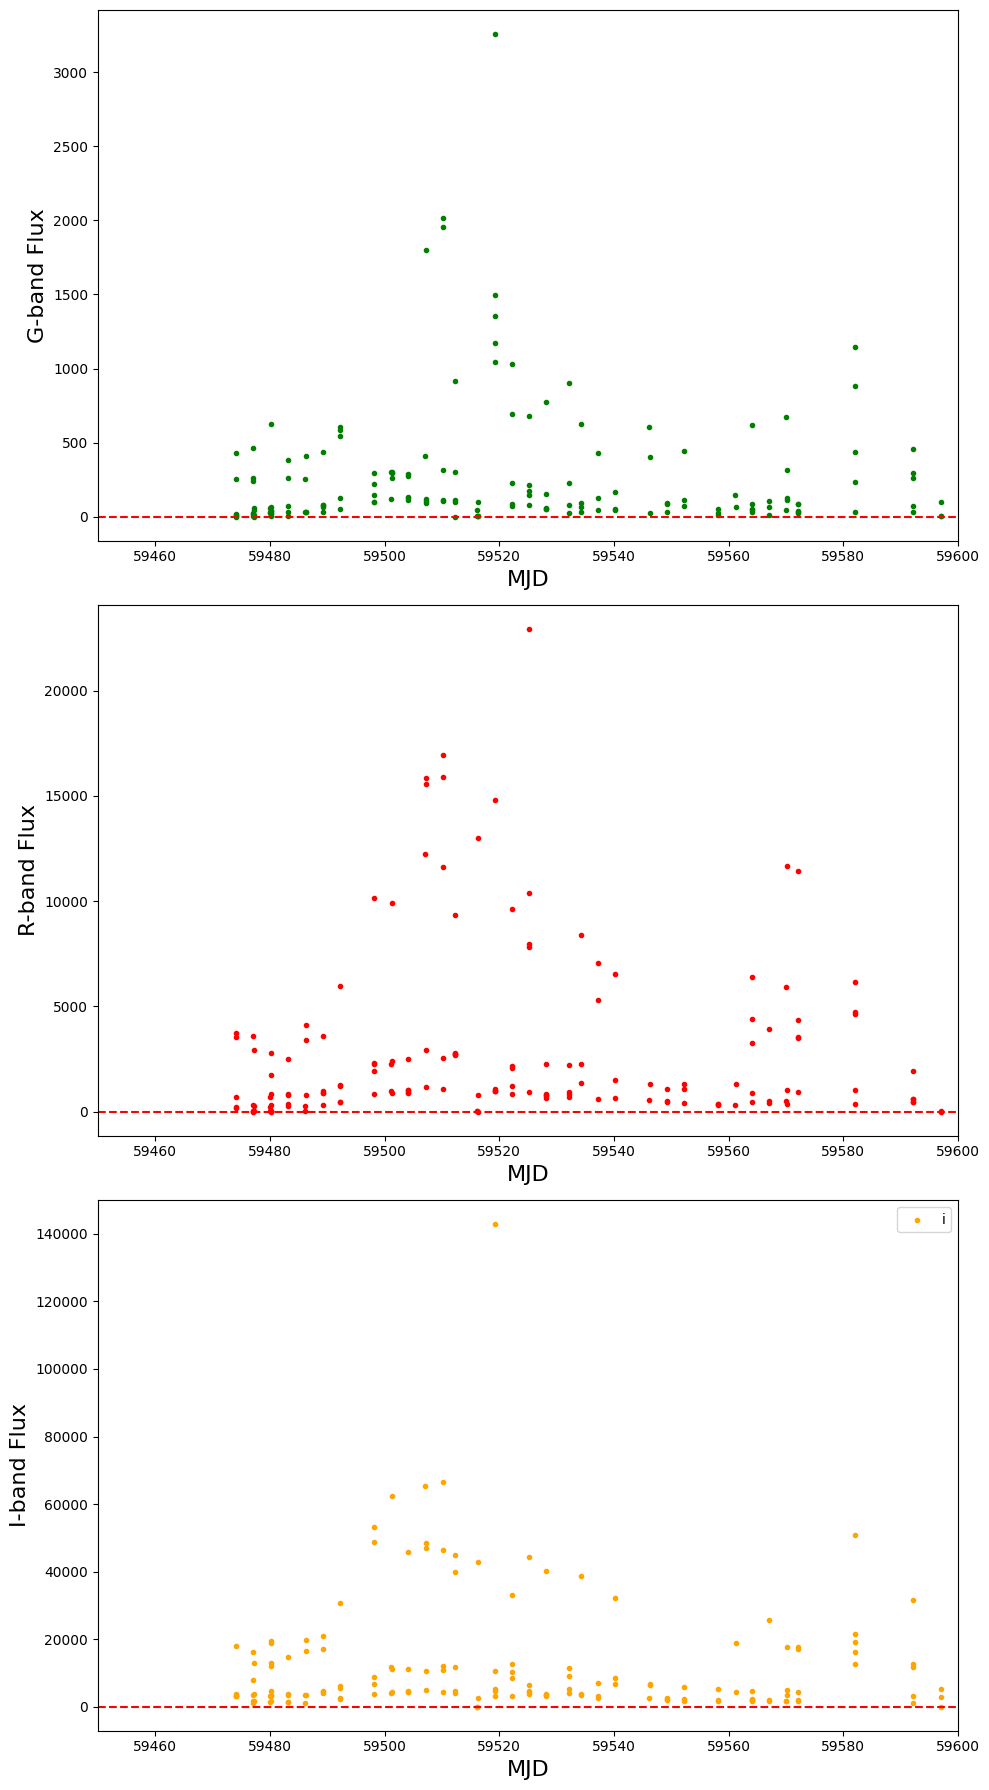

In [31]:
fig, axes = plt.subplots(3,1, figsize=[10,18])

indgal=indtransient+1
zps = np.asfarray(zps)
flux = scene_.sources[indtransient].spectrum.data * np.sum(scene_.sources[indtransient].morphology(),
                                                           axis=(-2,-1)) 
fluxgal = scene_.sources[indgal].spectrum.data * np.sum(scene_.sources[indgal].morphology(),axis=(-2,-1)) 
times=np.asfarray(times)
for bind,(b,c) in enumerate(zip(['g','r','i'],['green','red','orange'])):
        fluxes = flux[epochs==b]
        fluxes = [fluxes[i] * 10**((zp0[b]-zps[i])/2.5) for i in range(len(fluxes))]
        axes[bind].scatter(times[epochs==b],fluxes,
                    label=b,color=c,marker='.')
        # testdata = pd.DataFrame({'mjd': times[epochs==b], 'flux': flux[epochs==b]})
        # testdata.to_csv(f"{data_dir}/{obj_name}_{b}band.dat", index=False)
        # axes[bind].scatter(phot_data[bind].mjd, phot_data[bind].flux, color='b', 
        #                    label='Ap Phot', marker='.')
        # axes[bind].invert_yaxis()
        axes[bind].set_xlim([59450, 59600])
        # axes[bind].set_ylim([-500, 2500])
        axes[bind].plot([59450, 59600], [0, 0], 'r--')
        axes[bind].set_ylabel(f"{b.upper()}-band Flux", fontsize=16)
        axes[bind].set_xlabel("MJD", fontsize=16)
# plt.xlabel('MJD-57700')
# plt.suptitle(f"{obj_name} light curves", fontsize=20)
plt.tight_layout()
plt.legend()
plt.savefig(f"figs/{obj_name}_lc_sample.png", bbox_inches='tight')
plt.show()

In [ ]:
scene_.set_info(scene_.parameters.keys(), fixed=True) 
scene_.set_info('sources.'+str(indtransient)+'.spectrum.data', fixed=False, 
                # can set this to true, with galaxy morphology
                prior=dist.Normal(scene_.sources[indtransient].spectrum.data, 
                                  0.5*scene_.sources[indtransient].spectrum.data))
#prior=dist.Uniform(scene_.sources[0].spectrum.data-2.5,scene_.sources[0].spectrum.data+2.5))
##01scene.sources[5].spectrum.data))#dist.Uniform(
#scene_.sources[5].spectrum.data-2,scene_.sources[5].spectrum.data+2)) 
mcmc = scene_.sample(observations_sc2,num_warmup=100, num_samples=1000) 
q = mcmc.get_samples()['sources.'+str(indtransient)+'.spectrum.data'] 
q1 = np.percentile(q,[2.5,16,50,84,97.5],axis=0) 
fac = np.sum(scene_.sources[indtransient].morphology(),axis=(-2,-1))
fluxes = [] 
fluxerrors = [] 
for i in range(q1.shape[1]): 
    print(i,'median = ',q1[2][i],'std = ',(q1[3][i]-q1[1][i])/2) 
    fluxes.append(q1[2][i]*fac) 
    fluxerrors.append((q1[3][i]-q1[1][i])/2*fac)

mcmc.print_summary() 
#Uncomment this to show the corner plot
#corner.corner(mcmc).show() 
#plt.savefig(plotdir+'/'+srcname+'_transientflux_corner.png')
#plt.show()
#plt.clf()
zps = np.asfarray(zps)
fluxes = np.asfarray(fluxes)
fluxerrors = np.asfarray(fluxerrors)
times=np.asfarray(times)
# print(times,epochs,flux,fluxerrors)


fac = np.sum(scene_.sources[indtransient].morphology(),axis=(-2,-1))

# plt.savefig(plotdir+'/'+srcname+'_lc_flux.png')
# plt.show()
# plt.clf()
# outlchead=['MJD','FLUX','FLUXERR','BAND']
# outlc=np.column_stack((times,fluxes,fluxerrors,epochs))
# outlc = np.vstack((outlchead,outlc))
# np.savetxt(plotdir+'/lc.txt',np.asarray(outlc,dtype=str),fmt='%s')
# sed=[]
# sederr=[]
# for b,c in zip(bandall,['green','orange','red','purple','blue']):
#     sed.append(np.mean(fluxes[epochs==b]))
#     sederr.append(np.std(fluxes[epochs==b]))
#     plt.errorbar(times[epochs==b]-57700,25-2.5*np.log10(fluxes[epochs==b]),
#                  yerr = 1.0857*fluxerrors[epochs==b]/fluxes[epochs==b],
#                  linestyle='',label=b,color=c,marker='.')#+fluxgal[epochs==b]),label=b,color=c,marker='.')
# plt.xlabel('MJD-57700')
# plt.ylabel('Magnitude')
# plt.gca().invert_yaxis()
# plt.legend()
# plt.savefig(plotdir+'/'+srcname+'_lc_mag.png')
# plt.show()

  0%|          | 0/1100 [00:00<?, ?it/s]2024-03-15 15:08:17.431981: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 18m58.892636163s

********************************
[Compiling module jit__body_fn] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
sample:  11%|█         | 123/1100 [19:03:35<146:16:22, 538.98s/it, 1023 steps of size 1.24e-04. acc. prob=0.84]

In [ ]:
fig, axes = plt.subplots(3,1,figsize=[10,15])

for bind,(b,c) in enumerate(zip(bandall,['green','red','orange'])):
    axes[bind].errorbar(times[epochs==b],fluxes[epochs==b],
                        yerr = fluxerrors[epochs==b],linestyle='',label=b,
                        color=c,marker='.')#+fluxgal[epochs==b]),label=b,color=c,marker='.')
    axes[bind].set_xlim([59450, 59600])
    axes[bind].set_xlabel('MJD')
    axes[bind].set_ylabel('Flux')
    axes[bind].legend()
plt.title(obj_name)

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=[10,15])

for bind,(b,c) in enumerate(zip(bandall,['green','red','orange'])):
    axes[bind].errorbar(times[epochs==b],fluxes[epochs==b],
                 yerr = fluxerrors[epochs==b],linestyle='',
                 capsize=5,label=b,color=c,marker='.')
    axes[bind].set_xlim([59450, 59600])
    axes[bind].set_xlabel('MJD')
    axes[bind].set_ylabel('Flux')
    axes[bind].legend()
plt.title(f"{obj_name} light curves")
# plt.savefig(plotdir+'/'+srcname+'_lc_flux.png')
plt.show()
plt.clf()
# Make sure the prior makes sense given original flux